<a href="https://colab.research.google.com/github/aliaghababaee/SLO_Asieh/blob/main/VGG_%2B_Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold (n_splits = 5, shuffle = True, random_state = None)

In [3]:
import tensorflow as tf
from keras.layers import Input
import numpy as np
import pickle
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
!unzip /content/drive/MyDrive/train_thickness_retina_iran.zip

Archive:  /content/drive/MyDrive/train_thickness_retina_iran.zip
 extracting: train_labels.pkl        
 extracting: train_thickness_retina.pkl  
 extracting: train_sp.pkl            


In [5]:
!unzip /content/drive/MyDrive/test_thickness_retina_iran.zip

Archive:  /content/drive/MyDrive/test_thickness_retina_iran.zip
 extracting: test_labels.pkl         
 extracting: test_thickness_retina.pkl  
 extracting: test_sp.pkl             


In [6]:
!unzip /content/drive/MyDrive/train_SLO_iran.zip

Archive:  /content/drive/MyDrive/train_SLO_iran.zip
 extracting: train_slo_iran.pkl      
 extracting: train_labels_Iran.pkl   
 extracting: train_sp_iran.pkl       


In [7]:
!unzip /content/drive/MyDrive/test_SLO_iran.zip

Archive:  /content/drive/MyDrive/test_SLO_iran.zip
 extracting: test_slo_iran.pkl       
 extracting: test_labels_Iran.pkl    
 extracting: test_sp_iran.pkl        


# Typical Run

In [24]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold (n_splits = 5, shuffle = True, random_state = None)

In [46]:
import tensorflow as tf
from keras.layers import Input
import numpy as np
import pickle
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import ConfusionMatrixDisplay

In [26]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


def Augmentation_1 (x_train, labels_train):

    # augmentation
    batch=np.zeros_like(x_train, dtype=np.float32)
    batch_label=np.zeros_like(labels_train, dtype=np.float32)


    datagen = ImageDataGenerator(
    rotation_range= 5, # rotation
    zoom_range = 0.1,
    fill_mode='nearest',
    data_format='channels_last',
      )


    for i in range(len(x_train)):
        x1=x_train[i,:,:,:].copy()
        x1=x1.reshape((1, ) + x1.shape)
        x = datagen.flow(x1, batch_size=1, seed=2020) # to make the result reproducible


        batch[i,:,:,:] = x.next()
        batch_label[i] = labels_train[i]

    return batch, batch_label

In [27]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


def Augmentation_2 (x_train, labels_train):

    # augmentation
    batch=np.zeros_like(x_train, dtype=np.float32)
    batch_label=np.zeros_like(labels_train, dtype=np.float32)

    datagen = ImageDataGenerator(
        rotation_range= 10, # rotation
        width_shift_range= [-30, 30], # horizontal shift
        #height_shift_range= [-5, 5] , # vertical shift
        zoom_range= 0.2,
        vertical_flip= True , # vertical flip
        #brightness_range= [0.2, 1.5],
          )

    for i in range(len(x_train)):
        x1=x_train[i,:,:,:].copy()
        x1=x1.reshape((1, ) + x1.shape)
        x = datagen.flow(x1, batch_size=1, seed=2020) # to make the result reproducible


        batch[i,:,:,:] = x.next()
        batch_label[i] = labels_train[i]

    ###################################################################
    # Final data
    ###################################################################

    x = np.concatenate([x_train,batch])

    labels = np.concatenate([labels_train,batch_label])

    ############################

    ############################
    return x, labels

In [28]:
from skimage.transform import resize

In [54]:
import numpy as np
def preparing(x, y):

    data  = []
    label = []
    for i in x:
        for j in range(len(x[i])):

            data.append(np.array(x[i][j] ))
            label.append(y[i])

            #img = resize (x[i][j], (224, 224, 1), mode = 'constant', preserve_range= True)
            #data.append(img)
            #label.append(y[i])

    data = np.reshape(data, np.shape(data))
    return data, np.array(label)

(296, 60, 256, 3)

In [30]:
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve, auc
import numpy as np
from sklearn import metrics
import sklearn

# TP = confusion[1,1] # true positive
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

def metrics_calculation(y_valid, y_pred, y_prob):

    #####################################################
    #Get the confusion matrix
    #####################################################
    ROC_AUC = roc_auc_score(y_valid, y_prob)
    f1 = metrics.f1_score(y_valid, y_pred, average='weighted')
    precision, recall, thresholds = precision_recall_curve(y_valid, y_prob)
    P_R_AUC = auc(recall, precision)
    cm = sklearn.metrics.confusion_matrix(y_valid, y_pred, normalize='pred')
    #Now the normalize the diagonal entries
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    class_acc = cm.diagonal()

    Specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    Sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    Precision   = cm[1,1]/(cm[0,1]+cm[1,1])


    return Specificity, Sensitivity, Precision, f1, ROC_AUC, P_R_AUC, class_acc, cm

In [31]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc

def curve_ploting(ax, axx, mean_fpr, aucs, tprs, y_test, y_pred, classifier, kernel=[]):

    ###################### Continuing Ploting ROC curve for each fold and the mean ############

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
    )

    if kernel:
        ax.set_title(f"ROC Curve of {classifier} classifier ({kernel} kernel) ")
    else:
        ax.set_title(f"ROC Curve of {classifier} classifier")
    ax.legend(loc="lower right")

    ###################### Continuing Ploting P_R_curve for each fold and the mean ############
    ###

    no_skill = len(np.array(y_test)[np.array(y_test)==1]) / len(np.array(y_test))

    axx.plot([0, 1], [no_skill, no_skill], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    precision, recall, _ = precision_recall_curve(y_test, y_pred)

    axx.plot(
        recall,
        precision,
        color="b",
        label=r"Mean P_R curve (AUC =  %0.2f)" % (auc(recall, precision)),
        lw=2,
        alpha=0.8,
    )


    # axis labels
    axx.set_xlabel('Recall')
    axx.set_ylabel('Precision')
    # show the legend
    axx.legend(loc="lower left")
    if kernel:
        axx.set_title(f'Precision-Recall Curve of {classifier} classifier ({kernel} kernel)')
    else:
        axx.set_title(f'Precision-Recall Curve of {classifier} classifier')

In [32]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score
import numpy as np

def fold_curves(ax, axx, y_valid, fold_number, mean_fpr, pred_proba, tprs=[], aucs=[]):
    ############ ROC Curve
    lr_fpr, lr_tpr, _ = roc_curve(y_valid, pred_proba)
    roc_auc = roc_auc_score(y_valid, pred_proba)
    ax.plot(lr_fpr, lr_tpr, lw=1, alpha=0.3, label=r"P_R_curve fold %d (AUC =  %0.2f)" % (fold_number, roc_auc))
    # axis labels
    ax.set_xlabel('False Positive Rate (Positive label: 1.0)')
    ax.set_ylabel('True Positive Rate (Positive label: 1.0)')

    interp_tpr = np.interp(mean_fpr, lr_fpr, lr_tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)


    ############ P_R Curve
    precision, recall, _ = precision_recall_curve(y_valid, pred_proba)
    # plot the model precision-recall curve
    axx.plot(recall, precision, lw=1, alpha=0.3, label=r"P_R_curve fold %d (AUC =  %0.2f)" % (fold_number, auc(recall, precision)))

    return tprs, aucs

In [ ]:
number_class=2
cnn_accc_5iteration=[]
cnn_spp_5iteration=[]
cnn_see_5iteration=[]
cnn_prr_5iteration=[]
cnn_f11_5iteration=[]
cnn_aucc_5iteration=[]
cnn_pr_aucc_5iteration=[]
class_acc_5iteration = np.zeros((5,number_class))


test_accc_5iteration=[]
test_spp_5iteration=[]
test_see_5iteration=[]
test_prr_5iteration=[]
test_f11_5iteration=[]
test_aucc_5iteration=[]
test_pr_aucc_5iteration=[]
class_acc_test_5iteration = np.zeros((5,number_class))
n_iter=0

In [ ]:
x_train.shape

(304, 60, 256, 3)

vgg16

In [ ]:
#feature extractor for vgg16

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout

def cnn_feature_extractor(input_img, n_filters=32, n_class=2):

    # # Creating model
    base_model = tf.keras.applications.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(60, 256, 3),
        )


      ################## fine tune
    # for layer in base_model.layers[:-5]:
    #   layer.trainable = False
    base_model.trainable = False

    model = Sequential ()

    model.add (base_model)
    #flatten
    model.add(Flatten())
    model.add(Dense(1185, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1160, activation='relu'))
    model.add(Dropout(0.0))
    model.add(Dense(622, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(3692, activation='relu'))
    model.add(Dropout(0.7))
    ##################################
    #################################  EFFECT OF Hidden NEURONS  ###################
    model.add(Dense(3544, activation='relu'))
    model.add(Dense((n_class-1), activation='sigmoid'))
    return model


resnet101 with 255

In [17]:
#feature extractor for vgg16

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout

def cnn_feature_extractor(input_img, n_filters=32, n_class=2):

    # # Creating model
    base_model = tf.keras.applications.resnet.ResNet101(
        weights='imagenet',
        include_top=False,
        input_shape=(60, 256, 3))


      ################## fine tune
    # for layer in base_model.layers[:-5]:
    #   layer.trainable = False
    base_model.trainable = False

    model = Sequential ()

    model.add (base_model)
    #flatten
    model.add(Flatten())

    model.add (Dense (482, activation = 'relu'))
    model.add(Dropout(0.1))
    model.add (Dense (4019, activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(332, activation='relu'))
    model.add(Dropout(0.6))
    #model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.7))
    ##################################
    #################################  EFFECT OF Hidden NEURONS  ###################
    #model.add(Dense(3544, activation='relu'))
    model.add(Dense(n_class-1, activation='sigmoid'))
    return model


Resnet101 without 255

In [ ]:
#Resnet101 without 255


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout

def cnn_feature_extractor(input_img, n_filters=32, n_class=2):

    # # Creating model
    base_model = tf.keras.applications.resnet.ResNet101(
        weights='imagenet',
        include_top=False,
        input_shape=(60, 256, 3))


      ################## fine tune
    # for layer in base_model.layers[:-5]:
    #   layer.trainable = False
    base_model.trainable = False

    model = Sequential ()

    model.add (base_model)
    #flatten
    model.add(Flatten())


    model.add (Dense (2335, activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(n_class-1, activation='sigmoid'))
    return model


resnet 50

In [ ]:
#Resnet101 without 255


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout

def cnn_feature_extractor(input_img, n_filters=32, n_class=2):

    # # Creating model
    base_model = tf.keras.applications.resnet.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(60, 256, 3))


      ################## fine tune
    # for layer in base_model.layers[:-5]:
    #   layer.trainable = False
    base_model.trainable = False

    model = Sequential ()

    model.add (base_model)
    #flatten
    model.add(Flatten())


    model.add (Dense (102, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_class-1, activation='sigmoid'))
    return model


custom CNN

In [56]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout, Input

def cnn_feature_extractor(n_filters=20, n_class=2):


  model = Sequential()
  input_img = Input((60, 256, 1))

  model.add(Conv2D(n_filters * 1, kernel_size=3, activation='relu',input_shape= input_img.shape[1:], padding='same'))
  model.add(MaxPool2D(2, 2))
  model.add(BatchNormalization())


  model.add(Conv2D(n_filters * 2, kernel_size=3, activation='relu', padding='same'))
  model.add(MaxPool2D(2, 2))
  model.add(BatchNormalization())


  model.add(Conv2D(n_filters * 4, kernel_size=3, activation='relu',padding='same'))
  model.add(MaxPool2D(2, 2))
  model.add(BatchNormalization())


  model.add(Conv2D(n_filters * 8, kernel_size=3, activation='relu',padding='same'))
  model.add(MaxPool2D(2, 2))
  model.add(BatchNormalization())



  model.add(Flatten())

  model.add (Dropout (0.3))

  model.add(Dense(30, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(898, activation='relu'))
  model.add(Dropout(0.4))

  model.add(Dense(944, activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(116, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense((n_class-1), activation='sigmoid'))

  return model

In [ ]:
plt.imshow (x_train [270,:,:,0], cmap = 'jet')

In [ ]:
model.summary ()

In [43]:
images_test.shape

(38, 60, 256, 1)

In [ ]:
model = cnn_feature_extractor ()

In [ ]:
images_train = pickle.load(open("/content/" + "train_thickness_retina.pkl", 'rb'))
labels_train = pickle.load(open("/content/" +"train_labels.pkl", 'rb'))

images_test = pickle.load(open("/content/drive/MyDrive/" +"test_thickness_new.pkl", 'rb'))
labels_test = pickle.load(open("/content/" +"test_labels.pkl", 'rb'))
images_test,labels_test = preparing(images_test,labels_test)

#images_test = np.repeat (images_test, repeats = 3, axis = 3)
#####################################################################
## Parameters
#####################################################################
channel = 1
number_class = 2

cnn_acc    = []
cnn_se     = []
cnn_sp     = []
cnn_pr     = []
cnn_f1     = []
cnn_auc    = []
cnn_pr_auc = []

test_acc    = []
test_se     = []
test_sp     = []
test_pr     = []
test_f1     = []
test_auc    = []
test_pr_auc = []


class_acc = np.zeros((number_class))
class_acc_test = np.zeros((number_class))

target_names = ['Normal' , 'MS']
confusion_matrix = np.zeros((number_class, number_class))
confusion_matrix_test = np.zeros((number_class, number_class))

y_test = []
tprs   = []
aucs   = []
y_pred = []
x_test = {}

mean_fpr  = np.linspace(0, 1, 100)
fig, ax   = plt.subplots(figsize=(5, 5))
fig1, ax1 = plt.subplots(figsize=(5, 5))


#### model parameters for vgg
batch_size_vgg    = 8
epoch         = 100
filter_num    = 32
learning_rate_vgg =  0.0004036650839061106




#### model parameters for res101 with 255
batch_size_res255    = 64
epoch         = 100
filter_num    = 32
learning_rate_res255 =  0.0003720165816110892


#### model parameters for res101 without 255
batch_size_res    = 32
epoch         = 100
filter_num    = 32
learning_rate_res =  0.008509082186113752


#### model parameters for res50 with 255
batch_size_res50    = 16
epoch         = 100
filter_num    = 32
learning_rate_res50 =  0.002658420292718515


#### model parameters for cnn
batch_size_cnn    = 32
epoch         = 100
filter_num    = 32
learning_rate_cnn =   9.569191503177762e-05

#####################################################################
## Applying kfold
#####################################################################

nfold = 5  #please enter number of folds

kf_nfold = StratifiedKFold(n_splits=nfold, random_state=None, shuffle=True)

n = 0
for train_index, val_index in kf_nfold.split(images_train,list(labels_train.values())):
    n = n+1
    # print(train_index, val_index)  # you can watch train and validation index using this comment
    print(f'---------------------------------------------------------------------\
          \n \t\t\t {n}th fold \n---------------------------------------------------------------------'\
          ,end = '\n\n\n' )
    train_index, val_index = next (skf.split (images_train, list(labels_train.values())))

    x_train = {i: images_train[list(images_train.keys())[i]]  for i in train_index}

    x_valid = {i: images_train[list(images_train.keys())[i]]  for i in val_index}

    y_train = {i: labels_train[list(labels_train.keys())[i]] for i in train_index}

    y_valid = {i: labels_train[list(labels_train.keys())[i]] for i in val_index}

    x_train,y_train = preparing(x_train,y_train)

    x_valid,y_valid = preparing(x_valid,y_valid)

    #x_test[n] = x_valid
    ################# Augmentation

    indices = np.where(y_train == 1)[0]

    x_train_ms = x_train[indices]
    y_train_ms = y_train[indices]

    x_train_ms_aug,y_train_ms_aug = Augmentation_1(x_train_ms,y_train_ms)

    x_train = np.concatenate ((x_train, x_train_ms_aug), axis=0)
    y_train = np.concatenate ((y_train, y_train_ms_aug), axis = 0)

    indices = np.random.permutation (len (x_train))

    x_train_shuf = x_train [indices]
    y_train_shuf = y_train [indices]

    x_train,y_train = Augmentation_2(x_train_shuf,y_train_shuf)

    indices = np.random.permutation (len (x_train))

    x_train = x_train [indices]
    y_train = y_train [indices]

    #x_train = np.repeat (x_train, repeats = 3, axis = 3)

    #x_valid = np.repeat (x_valid, repeats = 3, axis = 3)

    ####################################################################
    # classification
    ####################################################################

    input_img = Input((np.shape(x_train)[1], np.shape(x_train)[2], channel))

    model = cnn_feature_extractor()


    METRICS = [
#      keras.metrics.TruePositives(name='tp'),
#      keras.metrics.FalsePositives(name='fp'),
#      keras.metrics.TrueNegatives(name='tn'),
#      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
#      keras.metrics.Precision(name='precision'),
#      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
#      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      ]


    my_optimizer =  tf.keras.optimizers.Adam(lr=learning_rate_cnn)
    model.compile(optimizer=my_optimizer, loss="binary_crossentropy", metrics=METRICS)
    callbacks = [EarlyStopping(patience=20, verbose=1),
        ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-6),
        ModelCheckpoint(f'oct{n}.h5', verbose=1, save_best_only=True, save_weights_only=True)]

    model.summary()

    #################################
    ###### Applying model  ###########
    #################################
    results = model.fit(x_train, y_train, batch_size=batch_size_cnn, epochs=epoch, callbacks=callbacks,\
                    validation_data=(x_valid, np.asarray(y_valid, dtype=np.float64)))


    plt.figure(figsize=(5, 5))
    plt.title(f"Learning curve {n}th fold")
    plt.plot(results.history["loss"][:-7], label="loss")
    plt.plot(results.history["val_loss"][:-7], label="val_loss")
    plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend()

    plt.figure(figsize=(5, 5))
    plt.title(f"Learning curve {n}th fold")
    plt.plot(results.history["accuracy"], label="accuracy")
    plt.plot(results.history["val_accuracy"], label="val_accuracy")
    plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]),\
             marker="x", color="r", label="best accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("accuracy")
    plt.legend()


    # load the best model
    model.load_weights(f'oct{n}.h5')


    pred_proba = model.predict(x_valid).ravel()
    pred_class = (pred_proba > 0.5).astype(np.uint8)


    ##### calculating metrics

    cnn_acc.append(metrics.accuracy_score(y_valid, pred_class))
    print(f'accuracy of {n}th fold : {metrics.accuracy_score(y_valid, pred_class)}')
    SP, SE, PR, f1, ROC_AUC, P_R_AUC, Class_acc, cm = metrics_calculation(y_valid, pred_class, pred_proba)

    cnn_sp.append(SP)
    cnn_se.append(SE)
    cnn_pr.append(PR)
    cnn_f1.append(f1)
    cnn_auc.append(ROC_AUC)
    cnn_pr_auc.append(P_R_AUC)

    #################### acc for each class ##################
    class_acc  = np.add(class_acc,Class_acc)

    ###################### Total confusion_matrix for poly kernel ############
    confusion_matrix = np.add(confusion_matrix,cm)

######################## internal test
    pred_proba_test = model.predict(images_test).ravel()
    pred_class_test = (pred_proba_test > 0.5).astype(np.uint8)


    ##### calculating metrics
    print(f'test accuracy of {n}th fold : {metrics.accuracy_score(labels_test, pred_class_test)}')
    SP, SE, PR, f1, ROC_AUC, P_R_AUC, Class_acc, cm = metrics_calculation(labels_test, pred_class_test, pred_proba_test)

    test_acc.append(metrics.accuracy_score(labels_test, pred_class_test))
    test_sp.append(SP)
    test_se.append(SE)
    test_pr.append(PR)
    test_f1.append(f1)
    test_auc.append(ROC_AUC)
    test_pr_auc.append(P_R_AUC)

    #################### acc for each class ##################
    class_acc_test  = np.add(class_acc_test,Class_acc)

    ###################### Total confusion_matrix for poly kernel ############
    confusion_matrix_test = np.add(confusion_matrix_test,cm)

    ###################### Ploting ROC and PR curves for each fold ############
    y_test = np.append(y_test, y_valid, axis = 0)
    y_pred = np.append(y_pred, pred_proba, axis = 0)
    ###
    tprs, aucs = fold_curves(ax, ax1, y_valid, n, mean_fpr, pred_proba, tprs, aucs)

######################  the mean Ploting ROC and PR curves ############
###
curve_ploting(ax, ax1, mean_fpr, aucs, tprs, y_test, y_pred, 'CNN' )

plt.show()

#######################################
    # ploting confusion matrix
#######################################
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix/nfold, display_labels=target_names)
disp.plot()


########################################
#     Metrics printing
########################################
cnn_accc     = np.mean(cnn_acc)
cnn_spp      = np.mean(cnn_sp)
cnn_see      = np.mean(cnn_se)
cnn_prr      = np.mean(cnn_pr)
cnn_f11      = np.mean(cnn_f1)
cnn_aucc     = np.mean(cnn_auc)
cnn_pr_aucc  = np.mean(cnn_pr_auc)

###################### internal test
test_accc     = np.mean(test_acc)
test_spp      = np.mean(test_sp)
test_see      = np.mean(test_se)
test_prr      = np.mean(test_pr)
test_f11      = np.mean(test_f1)
test_aucc     = np.mean(test_auc)
test_pr_aucc  = np.mean(test_pr_auc)

#################### acc for each class ##################
class_acc  = class_acc/nfold
class_acc_test  = class_acc_test/nfold

print('cnn_acc     = %f' % cnn_accc)
print('cnn_sp      = %f' % cnn_spp)
print('cnn_se      = %f' % cnn_see)
print('cnn_pr      = %f' % cnn_prr)
print('cnn_f1      = %f' % cnn_f11)
print('cnn_auc     = %f' % cnn_aucc)
print('cnn_pr_auc  = %f' % cnn_pr_aucc, end='\n\n')


print('acc of class %s' % target_names[0], '= %f' % class_acc[0])
print('acc of class %s' % target_names[1], '= %f' % class_acc[1], end='\n\n')

print('test_acc     = %f' % test_accc)
print('test_sp      = %f' % test_spp)
print('test_se      = %f' % test_see)
print('test_pr      = %f' % test_prr)
print('test_f1      = %f' % test_f11)
print('test_auc     = %f' % test_aucc)
print('test_pr_auc  = %f' % test_pr_aucc, end='\n\n')


print('test acc of class %s' % target_names[0], '= %f' % class_acc_test[0])
print('test acc of class %s' % target_names[1], '= %f' % class_acc_test[1], end='\n\n')

In [ ]:
x_train.shape

(302, 60, 256, 3)

In [24]:
test_acc

[0.9736842105263158,
 0.9473684210526315,
 0.9210526315789473,
 0.8421052631578947,
 0.9210526315789473]

In [25]:
cnn_acc

[1.0, 0.96875, 0.9354838709677419, 1.0, 0.9666666666666667]

# Optuna State of the arts

In [ ]:
!pip install optuna
!pip install optuna-integration
import optuna
from optuna.trial import TrialState
from optuna.integration import TFKerasPruningCallback

In [35]:
####################### state of the arts ##############################

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout
import tensorflow as tf
from keras.layers import Input

def classifier (trial):

  # Load the pre-trained VGG16 model without the top (fully connected) layers
  base_model = tf.keras.applications.resnet.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(60,256, 3),
        )



  # Freeze the pre-trained layers so they are not trainable during training
  #for layer in base_model.layers:
    #layer.trainable = False

  base_model.trainable = False

  model = Sequential ()

  model.add (base_model)

  model.add (Flatten ())

  dropout_l0 = trial.suggest_float("dropout_l0", 0, 0.7,step=0.1)

  model.add (Dropout (dropout_l0))


  n_layers = trial.suggest_int("n_layers", 1, 5)


  for i in range(n_layers):


      n_units = trial.suggest_int("n_units_l{}".format(i), 16, 4096, log = True)

      model.add (Dense (n_units, activation = 'relu'))

      dropout = trial.suggest_float("dropout_l{}".format (i+1), 0, 0.7,step=0.1)

      model.add (Dropout (rate = dropout))

  model.add (Dense (1, activation = 'sigmoid'))

  lr = trial.suggest_float ('lr', 1e-5, 1e-1, log = True)

  my_optimizer = tf.keras.optimizers.Adam (learning_rate= lr)


  model.compile(optimizer=my_optimizer, loss='binary_crossentropy', metrics='accuracy')


  return model

In [36]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold (n_splits = 5, shuffle = True, random_state = 42)
import keras
import pickle
from keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


def preparing(x, y):

    data  = []
    label = []
    for i in x:
        for j in range(len(x[i])):
            data.append(np.array(x[i][j] * 255))
            label.append(y[i])
            #img = resize (x[i][j], (224, 224, 1), mode = 'constant', preserve_range= True)
            #data.append (img)
            #label.append (y [i])


    data = np.reshape(data , np.shape(data))
    return data, np.array(label)




def objective (trial):

  keras.backend.clear_session()

  datagen = ImageDataGenerator(
  rotation_range= 5, # rotation
  zoom_range = 0.1,
  fill_mode='nearest',
  data_format='channels_last',
    )

  datagen2 = ImageDataGenerator(
  #rotation_range= 5, # rotation
  width_shift_range= [-30, 30], # horizontal shift
  #height_shift_range= [-5, 5] , # vertical shift
  zoom_range= 0.2,
  vertical_flip= True , # vertical flip
  #brightness_range= [0.2, 1.5]
    )


  images_train = pickle.load(open("/content/"+"train_thickness_retina.pkl", 'rb'))
  labels_train = pickle.load(open("/content/"+"train_labels.pkl", 'rb'))

  train_index, val_index = next (skf.split (images_train, list(labels_train.values())))

  x_train = {i: images_train[list(images_train.keys())[i]]  for i in train_index}

  x_valid = {i: images_train[list(images_train.keys())[i]]  for i in val_index}

  y_train = {i: labels_train[list(labels_train.keys())[i]] for i in train_index}

  y_valid = {i: labels_train[list(labels_train.keys())[i]] for i in val_index}

  x_train,y_train = preparing(x_train,y_train)

  x_valid,y_valid = preparing(x_valid,y_valid)


  #rotation_angle  = trial.suggest_float("rotation_angle", 0, 40, step = 10)
  #zoom_range = trial.suggest_float("zoom_range", 0, 0.5, step = 0.1)

  #color_jitter_brightness = trial.suggest_float ("color_jitter_brightness", 0.1, 0.8, step = 0.1)
  #shift_horizontal = trial.suggest_uniform("shift_horizontal", 0, 0.7)
  #shift_vertical = trial.suggest_uniform("shift_vertical", 0, 0.7)
  #vertical_flip_prob = trial.suggest_float ("vertical_flip_prob", 0, 1, step = 0.1)

  indices = np.where(y_train == 1)[0]

  x_train_ms = x_train[indices]
  y_train_ms = y_train[indices]
  #################Augmentation##################################

  # First Augmentation

  x_train_ms_aug =np.zeros_like(x_train_ms, dtype=np.float32)

  y_train_ms_aug =np.zeros_like(y_train_ms, dtype=np.float32)

  for i in range(len(x_train_ms)):

    x1= x_train_ms[i,:,:,:].copy()

    x1=x1.reshape((1, ) + x1.shape)

    x = datagen.flow(x1, batch_size=1, seed=42) # to make the result reproducible

    x_train_ms_aug [i,:,:,:] = x.next()

    y_train_ms_aug [i] = y_train[i]

  x_train = np.concatenate ((x_train, x_train_ms_aug), axis=0)
  y_train = np.concatenate ((y_train, y_train_ms_aug), axis = 0)

  indices = np.random.permutation (len (x_train))

  x_train_shuf = x_train [indices]
  y_train_shuf = y_train [indices]

  # Second Augmentation

  x_train_aug =np.zeros_like(x_train_shuf, dtype=np.float32)

  y_train_aug =np.zeros_like(y_train_shuf, dtype=np.float32)

  for i in range(len(x_train_aug)):

    x1= x_train_aug[i,:,:,:].copy()

    x1=x1.reshape((1, ) + x1.shape)

    x = datagen2.flow(x1, batch_size=1, seed=42) # to make the result reproducible

    x_train_aug [i,:,:,:] = x.next()

    y_train_aug [i] = y_train[i]

    x_train = np.concatenate ((x_train_shuf, x_train_aug), axis=0)
    y_train = np.concatenate ((y_train_shuf, y_train_aug), axis = 0)


  ###############################################################################33


  x_train = np.repeat (x_train, repeats = 3, axis = 3)

  x_valid = np.repeat (x_valid, repeats = 3, axis = 3)
        ####################################################################
        # classification via my model
        ####################################################################
  batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64, 128])

  model = classifier (trial)


  # Generate our trial model.


  model.fit(x_train,
            np.asarray(y_train, dtype=np.float64),
            batch_size= batch_size,
            epochs=50,
            callbacks=[TFKerasPruningCallback(trial, "val_accuracy"), EarlyStopping(patience=20, verbose=1),
            ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-6),
            ModelCheckpoint(f'slo.h5', verbose=1, save_best_only=True, save_weights_only=True)],
            validation_data=(x_valid, np.asarray(y_valid, dtype=np.float64)),
            )
  model.load_weights(f'slo.h5')
  score = model.evaluate (x_valid, np.asarray(y_valid, dtype=np.float64), verbose = 1)

  return score [1]


In [37]:
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())

study.optimize(objective, n_trials=100)

[I 2024-02-27 13:10:26,572] A new study created in memory with name: no-name-d217da3a-913a-40df-98fe-a327efb9a426


94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/50
37/38 [============================>.] - ETA: 0s - loss: 215.9333 - accuracy: 0.5743
Epoch 1: val_loss improved from inf to 21.11790, saving model to slo.h5
38/38 [==============================] - 7s 77ms/step - loss: 210.3427 - accuracy: 0.5789 - val_loss: 21.1179 - val_accuracy: 0.9032 - lr: 0.0150
Epoch 2/50
37/38 [============================>.] - ETA: 0s - loss: 16.9565 - accuracy: 0.6520
Epoch 2: val_loss improved from 21.11790 to 13.00579, saving model to slo.h5
38/38 [==============================] - 2s 41ms/step - loss: 16.7470 - accuracy: 0.6480 - val_loss: 13.0058 - val_accuracy: 0.8710 - lr: 0.0150
Epoch 3/50
37/38 [============================>.] - ETA: 0s - loss: 5.5060 - accuracy: 0.6926
Epoch 3: val_loss improved from 13.00579 to 0.22013, saving model to slo.h5
38/38 [==============================] - 2s 52ms/step - loss: 5.3718 - accuracy: 0.6875 - val_loss: 0.2201 - val_accuracy: 0.9032 - lr

[I 2024-02-27 13:11:00,961] Trial 0 finished with value: 0.8709677457809448 and parameters: {'batch_size': 8, 'dropout_l0': 0.5, 'n_layers': 2, 'n_units_l0': 2193, 'dropout_l1': 0.4, 'n_units_l1': 320, 'dropout_l2': 0.30000000000000004, 'lr': 0.015046730121581885}. Best is trial 0 with value: 0.8709677457809448.


Epoch 1/50
18/19 [===========================>..] - ETA: 0s - loss: 4.2443 - accuracy: 0.5625
Epoch 1: val_loss improved from inf to 0.24456, saving model to slo.h5
19/19 [==============================] - 6s 114ms/step - loss: 4.0793 - accuracy: 0.5592 - val_loss: 0.2446 - val_accuracy: 0.8065 - lr: 0.0040
Epoch 2/50
17/19 [=========================>....] - ETA: 0s - loss: 0.6820 - accuracy: 0.5515
Epoch 2: val_loss did not improve from 0.24456
19/19 [==============================] - 0s 13ms/step - loss: 0.7352 - accuracy: 0.5493 - val_loss: 0.2473 - val_accuracy: 0.9355 - lr: 0.0040
Epoch 3/50
17/19 [=========================>....] - ETA: 0s - loss: 0.6388 - accuracy: 0.5404
Epoch 3: val_loss did not improve from 0.24456
19/19 [==============================] - 0s 13ms/step - loss: 0.6407 - accuracy: 0.5428 - val_loss: 0.2675 - val_accuracy: 0.8387 - lr: 0.0040
Epoch 4/50
17/19 [=========================>....] - ETA: 0s - loss: 0.5776 - accuracy: 0.6250
Epoch 4: val_loss improved fr

[I 2024-02-27 13:11:21,756] Trial 1 finished with value: 0.9354838728904724 and parameters: {'batch_size': 16, 'dropout_l0': 0.7, 'n_layers': 1, 'n_units_l0': 30, 'dropout_l1': 0.7, 'lr': 0.003977746565261027}. Best is trial 1 with value: 0.9354838728904724.


Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 0.8999 - accuracy: 0.5888
Epoch 1: val_loss improved from inf to 0.46240, saving model to slo.h5
5/5 [==============================] - 9s 515ms/step - loss: 0.8999 - accuracy: 0.5888 - val_loss: 0.4624 - val_accuracy: 0.7097 - lr: 7.2342e-05
Epoch 2/50
3/5 [=================>............] - ETA: 0s - loss: 0.7444 - accuracy: 0.5990
Epoch 2: val_loss improved from 0.46240 to 0.45181, saving model to slo.h5
5/5 [==============================] - 1s 126ms/step - loss: 0.7713 - accuracy: 0.5987 - val_loss: 0.4518 - val_accuracy: 0.7097 - lr: 7.2342e-05
Epoch 3/50
3/5 [=================>............] - ETA: 0s - loss: 0.8022 - accuracy: 0.5156
Epoch 3: val_loss did not improve from 0.45181
5/5 [==============================] - 0s 36ms/step - loss: 0.7359 - accuracy: 0.5691 - val_loss: 0.4557 - val_accuracy: 0.7097 - lr: 7.2342e-05
Epoch 4/50
3/5 [=================>............] - ETA: 0s - loss: 0.6848 - accuracy: 0.5781

[W 2024-02-27 13:11:35,966] Trial 2 failed with parameters: {'batch_size': 64, 'dropout_l0': 0.1, 'n_layers': 4, 'n_units_l0': 40, 'dropout_l1': 0.0, 'n_units_l1': 35, 'dropout_l2': 0.7, 'n_units_l2': 20, 'dropout_l3': 0.1, 'n_units_l3': 20, 'dropout_l4': 0.2, 'lr': 7.234221982319829e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-36-9f7e61481ded>", line 148, in objective
    model.fit(x_train,
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handl

KeyboardInterrupt: 

In [ ]:
figure = plt.figure (figsize = (96, 96))
for i in range (len (x_train)):
  figure.add_subplot (20, 20, i+1)
  plt.imshow (x_train [i] [:,:,0], cmap = 'jet')
  plt.axis ('off')
plt.savefig ('augmented2.jpg')
plt.show ()

In [ ]:
x_train

In [ ]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  22
  Number of pruned trials:  13
  Number of complete trials:  8
Best trial:
  Value:  1.0
  Params: 
    batch_size: 16
    n_layers: 1
    n_units_l0: 102
    dropout_l0: 0.2
    lr: 0.002658420292718515


In [ ]:
!unzip /content/drive/MyDrive/train_thickness_retina_iran.zip

In [ ]:
!unzip /content/drive/MyDrive/test_thickness_retina_iran.zip

# Optuna Custom CNN

In [ ]:
!pip install optuna
!pip install optuna-integration
import optuna
from optuna.trial import TrialState
from optuna.integration import TFKerasPruningCallback

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout
import tensorflow as tf
from keras.layers import Input

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout
from keras.layers import Input

def classifier (trial):
  model = Sequential()
  input_img = Input((60, 256, 1))
  n_filters = trial.suggest_categorical("n_filters", [8, 16, 20, 25, 32, 64])
  print(f'n_filters = {n_filters}')

  model.add(Conv2D(n_filters * 1, kernel_size=3, activation='relu',input_shape=input_img.shape[1:], padding='same'))
  model.add(MaxPool2D(2, 2))
  model.add(BatchNormalization())


  model.add(Conv2D(n_filters * 2, kernel_size=3, activation='relu', padding='same'))
  model.add(MaxPool2D(2, 2))
  model.add(BatchNormalization())


  model.add(Conv2D(n_filters * 4, kernel_size=3, activation='relu',padding='same'))
  model.add(MaxPool2D(2, 2))
  model.add(BatchNormalization())


  model.add(Conv2D(n_filters * 8, kernel_size=3, activation='relu',padding='same'))
  model.add(MaxPool2D(2, 2))
  model.add(BatchNormalization())



  model.add (Flatten ())

  dropout_l0 = trial.suggest_float("dropout_l0", 0, 0.7,step=0.1)

  model.add (Dropout (dropout_l0))


  n_layers = trial.suggest_int("n_layers", 1, 5)


  for i in range(n_layers):

      n_units = trial.suggest_int("n_units_l{}".format(i), 8, 2048, log = True)

      model.add (Dense (n_units, activation = 'relu'))

      dropout = trial.suggest_float("dropout_l{}".format (i+1), 0, 0.7,step=0.1)

      model.add (Dropout (rate = dropout))

  model.add (Dense (1, activation = 'sigmoid'))

  lr = trial.suggest_float ('lr', 1e-5, 1e-3, log = True)

  my_optimizer = tf.keras.optimizers.Adam (learning_rate= lr)


  model.compile(optimizer=my_optimizer, loss='binary_crossentropy', metrics='accuracy')


  return model

In [21]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold (n_splits = 5, shuffle = True, random_state = 42)
import keras
import pickle
from keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


def preparing(x, y):

    data  = []
    label = []
    for i in x:
        for j in range(len(x[i])):
            data.append(np.array(x[i][j] * 255))
            label.append(y[i])


    data = np.reshape(data, np.shape(data))
    return data, np.array(label)




def objective (trial):

  keras.backend.clear_session()

  datagen = ImageDataGenerator(
  rotation_range= 5, # rotation
  zoom_range = 0.1,
  fill_mode='nearest',
  data_format='channels_last',
    )

  datagen2 = ImageDataGenerator(
  rotation_range= 10, # rotation
  width_shift_range= [-30, 30], # horizontal shift
  #height_shift_range= [-5, 5] , # vertical shift
  zoom_range= 0.2,
  vertical_flip= True , # vertical flip
  #brightness_range= [0.2, 1.5]
    )


  images_train = pickle.load(open("/content/"+"train_thickness_retina.pkl", 'rb'))
  labels_train = pickle.load(open("/content/"+"train_labels.pkl", 'rb'))

  train_index, val_index = next (skf.split (images_train, list(labels_train.values())))

  x_train = {i: images_train[list(images_train.keys())[i]]  for i in train_index}

  x_valid = {i: images_train[list(images_train.keys())[i]]  for i in val_index}

  y_train = {i: labels_train[list(labels_train.keys())[i]] for i in train_index}

  y_valid = {i: labels_train[list(labels_train.keys())[i]] for i in val_index}

  x_train,y_train = preparing(x_train,y_train)

  x_valid,y_valid = preparing(x_valid,y_valid)


  #rotation_angle  = trial.suggest_float("rotation_angle", 0, 40, step = 10)
  #zoom_range = trial.suggest_float("zoom_range", 0, 0.5, step = 0.1)

  #color_jitter_brightness = trial.suggest_float ("color_jitter_brightness", 0.1, 0.8, step = 0.1)
  #shift_horizontal = trial.suggest_uniform("shift_horizontal", 0, 0.7)
  #shift_vertical = trial.suggest_uniform("shift_vertical", 0, 0.7)
  #vertical_flip_prob = trial.suggest_float ("vertical_flip_prob", 0, 1, step = 0.1)

  indices = np.where(y_train == 1)[0]

  x_train_ms = x_train[indices]
  y_train_ms = y_train[indices]
  #################Augmentation##################################

  # First Augmentation

  x_train_ms_aug =np.zeros_like(x_train_ms, dtype=np.float32)

  y_train_ms_aug =np.zeros_like(y_train_ms, dtype=np.float32)

  for i in range(len(x_train_ms)):

    x1= x_train_ms[i,:,:,:].copy()

    x1=x1.reshape((1, ) + x1.shape)

    x = datagen.flow(x1, batch_size=1, seed=42) # to make the result reproducible

    x_train_ms_aug [i,:,:,:] = x.next()

    y_train_ms_aug [i] = y_train[i]

  x_train = np.concatenate ((x_train, x_train_ms_aug), axis=0)
  y_train = np.concatenate ((y_train, y_train_ms_aug), axis = 0)

  indices = np.random.permutation (len (x_train))

  x_train_shuf = x_train [indices]
  y_train_shuf = y_train [indices]

  # Second Augmentation

  x_train_aug =np.zeros_like(x_train_shuf, dtype=np.float32)

  y_train_aug =np.zeros_like(y_train_shuf, dtype=np.float32)

  for i in range(len(x_train_aug)):

    x1= x_train_aug[i,:,:,:].copy()

    x1=x1.reshape((1, ) + x1.shape)

    x = datagen2.flow(x1, batch_size=1, seed=42) # to make the result reproducible

    x_train_aug [i,:,:,:] = x.next()

    y_train_aug [i] = y_train[i]

  x_train = np.concatenate ((x_train_shuf, x_train_aug), axis=0)
  y_train = np.concatenate ((y_train_shuf, y_train_aug), axis = 0)

  indices = np.random.permutation (len (x_train))

  x_train_shuf = x_train [indices]
  y_train_shuf = y_train [indices]




  ###############################################################################33


  # x_train = np.repeat (x_train, repeats = 3, axis = 3)

  # x_valid = np.repeat (x_valid, repeats = 3, axis = 3)
        ####################################################################
        # classification via my model
        ####################################################################
  batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64, 128])

  model = classifier (trial)


  # Generate our trial model.


  model.fit(x_train,
            np.asarray(y_train, dtype=np.float64),
            batch_size= batch_size,
            epochs=50,
            callbacks=[TFKerasPruningCallback(trial, "val_accuracy"), EarlyStopping(patience=10, verbose=1),
            ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-6),
            ModelCheckpoint(f'oct.h5', verbose=1, save_best_only=True, save_weights_only=True)],
            validation_data=(x_valid, np.asarray(y_valid, dtype=np.float64)),
            )
  model.load_weights(f'oct.h5')
  score = model.evaluate (x_valid, np.asarray(y_valid, dtype=np.float64), verbose = 1)

  return score [1]


In [22]:
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())

study.optimize(objective, n_trials=100)

[I 2024-02-27 12:39:54,317] A new study created in memory with name: no-name-15b67a78-6d7a-4c45-a490-0fb702e89a76


n_filters = 25
Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 0.7041 - accuracy: 0.4967
Epoch 1: val_loss improved from inf to 0.68216, saving model to oct.h5
10/10 [==============================] - 6s 87ms/step - loss: 0.7041 - accuracy: 0.4967 - val_loss: 0.6822 - val_accuracy: 0.8387 - lr: 4.2516e-04
Epoch 2/50
 8/10 [=======================>......] - ETA: 0s - loss: 0.6886 - accuracy: 0.6172
Epoch 2: val_loss did not improve from 0.68216
10/10 [==============================] - 0s 11ms/step - loss: 0.6942 - accuracy: 0.5954 - val_loss: 0.8044 - val_accuracy: 0.2903 - lr: 4.2516e-04
Epoch 3/50
 8/10 [=======================>......] - ETA: 0s - loss: 0.6714 - accuracy: 0.5977
Epoch 3: val_loss improved from 0.68216 to 0.58017, saving model to oct.h5
10/10 [==============================] - 0s 15ms/step - loss: 0.6698 - accuracy: 0.6086 - val_loss: 0.5802 - val_accuracy: 0.7742 - lr: 4.2516e-04
Epoch 4/50
 8/10 [=======================>......] - ETA: 0s - loss: 0

[I 2024-02-27 12:40:07,281] Trial 0 finished with value: 0.9677419066429138 and parameters: {'batch_size': 32, 'n_filters': 25, 'dropout_l0': 0.4, 'n_layers': 3, 'n_units_l0': 18, 'dropout_l1': 0.2, 'n_units_l1': 49, 'dropout_l2': 0.6000000000000001, 'n_units_l2': 1791, 'dropout_l3': 0.30000000000000004, 'lr': 0.0004251586175764513}. Best is trial 0 with value: 0.9677419066429138.


n_filters = 20
Epoch 1/50
16/19 [========================>.....] - ETA: 0s - loss: 0.6943 - accuracy: 0.5703
Epoch 1: val_loss improved from inf to 0.64538, saving model to oct.h5
19/19 [==============================] - 6s 39ms/step - loss: 0.6968 - accuracy: 0.5724 - val_loss: 0.6454 - val_accuracy: 0.7097 - lr: 1.4355e-04
Epoch 2/50
17/19 [=========================>....] - ETA: 0s - loss: 0.7475 - accuracy: 0.5772
Epoch 2: val_loss did not improve from 0.64538
19/19 [==============================] - 0s 8ms/step - loss: 0.7228 - accuracy: 0.6020 - val_loss: 0.6541 - val_accuracy: 0.7097 - lr: 1.4355e-04
Epoch 3/50
17/19 [=========================>....] - ETA: 0s - loss: 0.6896 - accuracy: 0.5809
Epoch 3: val_loss did not improve from 0.64538
19/19 [==============================] - 0s 8ms/step - loss: 0.6975 - accuracy: 0.5691 - val_loss: 0.6707 - val_accuracy: 0.8710 - lr: 1.4355e-04
Epoch 4/50
17/19 [=========================>....] - ETA: 0s - loss: 0.6913 - accuracy: 0.5809
Epoch

[I 2024-02-27 12:40:25,684] Trial 1 finished with value: 0.9677419066429138 and parameters: {'batch_size': 16, 'n_filters': 20, 'dropout_l0': 0.5, 'n_layers': 5, 'n_units_l0': 1751, 'dropout_l1': 0.5, 'n_units_l1': 1131, 'dropout_l2': 0.30000000000000004, 'n_units_l2': 544, 'dropout_l3': 0.0, 'n_units_l3': 60, 'dropout_l4': 0.30000000000000004, 'n_units_l4': 706, 'dropout_l5': 0.6000000000000001, 'lr': 0.00014355064530003315}. Best is trial 0 with value: 0.9677419066429138.


n_filters = 16
Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 0.7931 - accuracy: 0.4309
Epoch 1: val_loss improved from inf to 0.79730, saving model to oct.h5
19/19 [==============================] - 5s 27ms/step - loss: 0.7931 - accuracy: 0.4309 - val_loss: 0.7973 - val_accuracy: 0.2903 - lr: 1.6251e-05
Epoch 2/50
10/19 [==============>...............] - ETA: 0s - loss: 0.7126 - accuracy: 0.5437
Epoch 2: val_loss improved from 0.79730 to 0.71836, saving model to oct.h5
19/19 [==============================] - 0s 9ms/step - loss: 0.7235 - accuracy: 0.5329 - val_loss: 0.7184 - val_accuracy: 0.2903 - lr: 1.6251e-05
Epoch 3/50
10/19 [==============>...............] - ETA: 0s - loss: 0.6668 - accuracy: 0.5938
Epoch 3: val_loss improved from 0.71836 to 0.68637, saving model to oct.h5
19/19 [==============================] - 0s 9ms/step - loss: 0.6512 - accuracy: 0.6349 - val_loss: 0.6864 - val_accuracy: 0.5484 - lr: 1.6251e-05
Epoch 4/50
19/19 [=========================

[I 2024-02-27 12:40:39,116] Trial 2 finished with value: 0.9354838728904724 and parameters: {'batch_size': 16, 'n_filters': 16, 'dropout_l0': 0.1, 'n_layers': 3, 'n_units_l0': 163, 'dropout_l1': 0.5, 'n_units_l1': 27, 'dropout_l2': 0.0, 'n_units_l2': 301, 'dropout_l3': 0.30000000000000004, 'lr': 1.6250738414467364e-05}. Best is trial 0 with value: 0.9677419066429138.


n_filters = 16
Epoch 1/50
 8/10 [=======================>......] - ETA: 0s - loss: 0.6862 - accuracy: 0.5664 
Epoch 1: val_loss improved from inf to 0.67086, saving model to oct.h5
10/10 [==============================] - 4s 40ms/step - loss: 0.6941 - accuracy: 0.5395 - val_loss: 0.6709 - val_accuracy: 0.7097 - lr: 2.6497e-05
Epoch 2/50
 8/10 [=======================>......] - ETA: 0s - loss: 0.6935 - accuracy: 0.5508
Epoch 2: val_loss did not improve from 0.67086
10/10 [==============================] - 0s 10ms/step - loss: 0.6855 - accuracy: 0.5625 - val_loss: 0.6710 - val_accuracy: 0.7097 - lr: 2.6497e-05
Epoch 3/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.6861 - accuracy: 0.5799
Epoch 3: val_loss improved from 0.67086 to 0.67006, saving model to oct.h5
10/10 [==============================] - 0s 13ms/step - loss: 0.6882 - accuracy: 0.5789 - val_loss: 0.6701 - val_accuracy: 0.7097 - lr: 2.6497e-05
Epoch 4/50
 8/10 [=======================>......] - ETA: 0s - loss: 

[I 2024-02-27 12:40:50,770] Trial 3 finished with value: 0.8387096524238586 and parameters: {'batch_size': 32, 'n_filters': 16, 'dropout_l0': 0.30000000000000004, 'n_layers': 4, 'n_units_l0': 62, 'dropout_l1': 0.30000000000000004, 'n_units_l1': 267, 'dropout_l2': 0.6000000000000001, 'n_units_l2': 138, 'dropout_l3': 0.2, 'n_units_l3': 1955, 'dropout_l4': 0.4, 'lr': 2.6496643392438178e-05}. Best is trial 0 with value: 0.9677419066429138.


n_filters = 16
Epoch 1/50
11/19 [================>.............] - ETA: 0s - loss: 1.2089 - accuracy: 0.5398 
Epoch 1: val_loss improved from inf to 0.83784, saving model to oct.h5
19/19 [==============================] - 3s 20ms/step - loss: 1.2009 - accuracy: 0.5461 - val_loss: 0.8378 - val_accuracy: 0.2903 - lr: 2.6635e-04
Epoch 2/50
11/19 [================>.............] - ETA: 0s - loss: 1.0023 - accuracy: 0.6136
Epoch 2: val_loss improved from 0.83784 to 0.65037, saving model to oct.h5
19/19 [==============================] - 0s 9ms/step - loss: 1.0331 - accuracy: 0.6020 - val_loss: 0.6504 - val_accuracy: 0.7742 - lr: 2.6635e-04
Epoch 3/50
11/19 [================>.............] - ETA: 0s - loss: 1.0588 - accuracy: 0.6193
Epoch 3: val_loss did not improve from 0.65037
19/19 [==============================] - 0s 7ms/step - loss: 1.0075 - accuracy: 0.6250 - val_loss: 1.1559 - val_accuracy: 0.2903 - lr: 2.6635e-04
Epoch 4/50
11/19 [================>.............] - ETA: 0s - loss: 0.

[I 2024-02-27 12:40:59,936] Trial 4 finished with value: 0.9677419066429138 and parameters: {'batch_size': 16, 'n_filters': 16, 'dropout_l0': 0.4, 'n_layers': 2, 'n_units_l0': 468, 'dropout_l1': 0.5, 'n_units_l1': 433, 'dropout_l2': 0.6000000000000001, 'lr': 0.00026634895431078357}. Best is trial 0 with value: 0.9677419066429138.


n_filters = 64
Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 1.0070 - accuracy: 0.5625

[I 2024-02-27 12:41:07,138] Trial 5 pruned. Trial was pruned at epoch 0.


n_filters = 20
Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 0.6837 - accuracy: 0.5724 
Epoch 1: val_loss improved from inf to 0.61084, saving model to oct.h5
5/5 [==============================] - 5s 178ms/step - loss: 0.6837 - accuracy: 0.5724 - val_loss: 0.6108 - val_accuracy: 0.7097 - lr: 3.1642e-04
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.7870 - accuracy: 0.5156
Epoch 2: val_loss did not improve from 0.61084
5/5 [==============================] - 0s 18ms/step - loss: 0.7044 - accuracy: 0.5461 - val_loss: 0.6768 - val_accuracy: 0.8065 - lr: 3.1642e-04
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.7635 - accuracy: 0.5625
Epoch 3: val_loss did not improve from 0.61084
5/5 [==============================] - 0s 19ms/step - loss: 0.7017 - accuracy: 0.5757 - val_loss: 0.6866 - val_accuracy: 0.8065 - lr: 3.1642e-04
Epoch 4/50
1/5 [=====>........................] - ETA: 0s - loss: 0.7297 - accuracy: 0.4844
Epoch 4: val_lo

[I 2024-02-27 12:41:13,814] Trial 6 pruned. Trial was pruned at epoch 9.


n_filters = 8
Epoch 1/50
33/38 [=========================>....] - ETA: 0s - loss: 1.1226 - accuracy: 0.5265
Epoch 1: val_loss improved from inf to 0.54044, saving model to oct.h5
38/38 [==============================] - 3s 15ms/step - loss: 1.1337 - accuracy: 0.5263 - val_loss: 0.5404 - val_accuracy: 0.8065 - lr: 3.5861e-05
Epoch 2/50
34/38 [=========================>....] - ETA: 0s - loss: 0.8285 - accuracy: 0.6360
Epoch 2: val_loss improved from 0.54044 to 0.48518, saving model to oct.h5
38/38 [==============================] - 0s 7ms/step - loss: 0.8514 - accuracy: 0.6217 - val_loss: 0.4852 - val_accuracy: 0.8065 - lr: 3.5861e-05
Epoch 3/50
33/38 [=========================>....] - ETA: 0s - loss: 0.9992 - accuracy: 0.5758
Epoch 3: val_loss did not improve from 0.48518
38/38 [==============================] - 0s 6ms/step - loss: 0.9494 - accuracy: 0.5855 - val_loss: 0.5705 - val_accuracy: 0.8387 - lr: 3.5861e-05
Epoch 4/50
34/38 [=========================>....] - ETA: 0s - loss: 0.86

[I 2024-02-27 12:41:22,931] Trial 7 pruned. Trial was pruned at epoch 20.


n_filters = 8
Epoch 1/50
30/38 [======================>.......] - ETA: 0s - loss: 0.7826 - accuracy: 0.5042
Epoch 1: val_loss improved from inf to 0.68538, saving model to oct.h5
38/38 [==============================] - 4s 13ms/step - loss: 0.7668 - accuracy: 0.5033 - val_loss: 0.6854 - val_accuracy: 0.7097 - lr: 3.9037e-04
Epoch 2/50
30/38 [======================>.......] - ETA: 0s - loss: 0.6986 - accuracy: 0.5250
Epoch 2: val_loss improved from 0.68538 to 0.66320, saving model to oct.h5
38/38 [==============================] - 0s 7ms/step - loss: 0.7015 - accuracy: 0.5230 - val_loss: 0.6632 - val_accuracy: 0.7097 - lr: 3.9037e-04
Epoch 3/50
30/38 [======================>.......] - ETA: 0s - loss: 0.7020 - accuracy: 0.5333
Epoch 3: val_loss improved from 0.66320 to 0.65030, saving model to oct.h5
38/38 [==============================] - 0s 7ms/step - loss: 0.6897 - accuracy: 0.5658 - val_loss: 0.6503 - val_accuracy: 0.7097 - lr: 3.9037e-04
Epoch 4/50
31/38 [=======================>..

[I 2024-02-27 12:41:28,143] Trial 8 pruned. Trial was pruned at epoch 3.


n_filters = 32
Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 1.4025 - accuracy: 0.5066 

[I 2024-02-27 12:41:33,885] Trial 9 pruned. Trial was pruned at epoch 0.


n_filters = 25
Epoch 1/50
3/3 [==============================] - ETA: 0s - loss: 0.7502 - accuracy: 0.4901
Epoch 1: val_loss improved from inf to 0.67643, saving model to oct.h5
3/3 [==============================] - 5s 364ms/step - loss: 0.7502 - accuracy: 0.4901 - val_loss: 0.6764 - val_accuracy: 0.7097 - lr: 8.2958e-04
Epoch 2/50
1/3 [=========>....................] - ETA: 0s - loss: 0.6733 - accuracy: 0.5625
Epoch 2: val_loss improved from 0.67643 to 0.66648, saving model to oct.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.6737 - accuracy: 0.5592 - val_loss: 0.6665 - val_accuracy: 0.8065 - lr: 8.2958e-04
Epoch 3/50
1/3 [=========>....................] - ETA: 0s - loss: 0.6537 - accuracy: 0.5312
Epoch 3: val_loss improved from 0.66648 to 0.60441, saving model to oct.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.6263 - accuracy: 0.5658 - val_loss: 0.6044 - val_accuracy: 0.7097 - lr: 8.2958e-04
Epoch 4/50
1/3 [=========>....................] - ET

[I 2024-02-27 12:41:40,355] Trial 10 pruned. Trial was pruned at epoch 9.


n_filters = 25
Epoch 1/50
18/19 [===========================>..] - ETA: 0s - loss: 0.6549 - accuracy: 0.6007

[I 2024-02-27 12:41:45,199] Trial 11 pruned. Trial was pruned at epoch 0.


n_filters = 20
Epoch 1/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.6678 - accuracy: 0.6161 
Epoch 1: val_loss improved from inf to 0.63676, saving model to oct.h5
10/10 [==============================] - 4s 42ms/step - loss: 0.6724 - accuracy: 0.5987 - val_loss: 0.6368 - val_accuracy: 0.7097 - lr: 9.5692e-05
Epoch 2/50
 8/10 [=======================>......] - ETA: 0s - loss: 0.6330 - accuracy: 0.6406
Epoch 2: val_loss did not improve from 0.63676
10/10 [==============================] - 0s 11ms/step - loss: 0.6302 - accuracy: 0.6382 - val_loss: 0.6383 - val_accuracy: 0.7419 - lr: 9.5692e-05
Epoch 3/50
 8/10 [=======================>......] - ETA: 0s - loss: 0.5750 - accuracy: 0.6875
Epoch 3: val_loss improved from 0.63676 to 0.63202, saving model to oct.h5
10/10 [==============================] - 0s 14ms/step - loss: 0.5861 - accuracy: 0.6776 - val_loss: 0.6320 - val_accuracy: 0.8065 - lr: 9.5692e-05
Epoch 4/50
 8/10 [=======================>......] - ETA: 0s - loss: 

[I 2024-02-27 12:41:56,184] Trial 12 finished with value: 1.0 and parameters: {'batch_size': 32, 'n_filters': 20, 'dropout_l0': 0.30000000000000004, 'n_layers': 4, 'n_units_l0': 30, 'dropout_l1': 0.1, 'n_units_l1': 898, 'dropout_l2': 0.4, 'n_units_l2': 944, 'dropout_l3': 0.2, 'n_units_l3': 116, 'dropout_l4': 0.1, 'lr': 9.569191503177762e-05}. Best is trial 12 with value: 1.0.


n_filters = 25
Epoch 1/50
 6/10 [=================>............] - ETA: 0s - loss: 0.7019 - accuracy: 0.5729 
Epoch 1: val_loss improved from inf to 0.65591, saving model to oct.h5
10/10 [==============================] - 4s 43ms/step - loss: 0.6890 - accuracy: 0.5954 - val_loss: 0.6559 - val_accuracy: 0.7097 - lr: 5.5237e-05
Epoch 2/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.6490 - accuracy: 0.6027
Epoch 2: val_loss did not improve from 0.65591
10/10 [==============================] - 0s 12ms/step - loss: 0.6593 - accuracy: 0.6020 - val_loss: 0.6579 - val_accuracy: 0.7097 - lr: 5.5237e-05
Epoch 3/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.6356 - accuracy: 0.6027
Epoch 3: val_loss did not improve from 0.65591
10/10 [==============================] - 0s 12ms/step - loss: 0.6288 - accuracy: 0.6118 - val_loss: 0.6633 - val_accuracy: 0.8387 - lr: 5.5237e-05
Epoch 4/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.5954 - accuracy: 0.6562
Ep

[I 2024-02-27 12:42:07,669] Trial 13 finished with value: 1.0 and parameters: {'batch_size': 32, 'n_filters': 25, 'dropout_l0': 0.30000000000000004, 'n_layers': 4, 'n_units_l0': 22, 'dropout_l1': 0.1, 'n_units_l1': 164, 'dropout_l2': 0.5, 'n_units_l2': 816, 'dropout_l3': 0.2, 'n_units_l3': 265, 'dropout_l4': 0.0, 'lr': 5.52370159774681e-05}. Best is trial 12 with value: 1.0.


n_filters = 20
Epoch 1/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.6917 - accuracy: 0.5625 
Epoch 1: val_loss improved from inf to 0.67393, saving model to oct.h5
10/10 [==============================] - 4s 44ms/step - loss: 0.6844 - accuracy: 0.5658 - val_loss: 0.6739 - val_accuracy: 0.7097 - lr: 6.0575e-05
Epoch 2/50
 8/10 [=======================>......] - ETA: 0s - loss: 0.6673 - accuracy: 0.5859
Epoch 2: val_loss did not improve from 0.67393
10/10 [==============================] - 0s 11ms/step - loss: 0.6645 - accuracy: 0.5822 - val_loss: 0.6836 - val_accuracy: 0.7419 - lr: 6.0575e-05
Epoch 3/50
 8/10 [=======================>......] - ETA: 0s - loss: 0.6442 - accuracy: 0.5977

[I 2024-02-27 12:42:12,648] Trial 14 pruned. Trial was pruned at epoch 2.


n_filters = 32
Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 0.6950 - accuracy: 0.5526
Epoch 1: val_loss improved from inf to 0.68937, saving model to oct.h5
10/10 [==============================] - 5s 80ms/step - loss: 0.6950 - accuracy: 0.5526 - val_loss: 0.6894 - val_accuracy: 0.7097 - lr: 6.5318e-05
Epoch 2/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.6837 - accuracy: 0.5938
Epoch 2: val_loss improved from 0.68937 to 0.67051, saving model to oct.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.6850 - accuracy: 0.5954 - val_loss: 0.6705 - val_accuracy: 0.7419 - lr: 6.5318e-05
Epoch 3/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.6427 - accuracy: 0.6071
Epoch 3: val_loss did not improve from 0.67051
10/10 [==============================] - 0s 12ms/step - loss: 0.6349 - accuracy: 0.6086 - val_loss: 0.6815 - val_accuracy: 0.8065 - lr: 6.5318e-05
Epoch 4/50
 7/10 [====================>.........] - ETA: 0s - loss: 0

[I 2024-02-27 12:42:21,169] Trial 15 pruned. Trial was pruned at epoch 20.


n_filters = 64
Epoch 1/50
3/3 [==============================] - ETA: 0s - loss: 0.7230 - accuracy: 0.5954 

[I 2024-02-27 12:42:28,466] Trial 16 pruned. Trial was pruned at epoch 0.


n_filters = 20
Epoch 1/50
 8/10 [=======================>......] - ETA: 0s - loss: 0.7247 - accuracy: 0.4727 

[I 2024-02-27 12:42:33,211] Trial 17 pruned. Trial was pruned at epoch 0.


n_filters = 25
Epoch 1/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.6997 - accuracy: 0.4732 

[I 2024-02-27 12:42:37,158] Trial 18 pruned. Trial was pruned at epoch 0.


n_filters = 20
Epoch 1/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.6816 - accuracy: 0.5625 

[I 2024-02-27 12:42:42,336] Trial 19 pruned. Trial was pruned at epoch 0.


n_filters = 25
Epoch 1/50
1/3 [=========>....................] - ETA: 7s - loss: 0.6945 - accuracy: 0.4375

[I 2024-02-27 12:42:47,861] Trial 20 pruned. Trial was pruned at epoch 0.


n_filters = 25
Epoch 1/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.7052 - accuracy: 0.5491 

[I 2024-02-27 12:42:52,276] Trial 21 pruned. Trial was pruned at epoch 0.


n_filters = 25
Epoch 1/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.6836 - accuracy: 0.4464 

[I 2024-02-27 12:42:56,519] Trial 22 pruned. Trial was pruned at epoch 0.


n_filters = 25
Epoch 1/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.7003 - accuracy: 0.5491 

[I 2024-02-27 12:43:00,826] Trial 23 pruned. Trial was pruned at epoch 0.


n_filters = 25
Epoch 1/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.7820 - accuracy: 0.6205 
Epoch 1: val_loss improved from inf to 0.66799, saving model to oct.h5
10/10 [==============================] - 4s 40ms/step - loss: 0.7814 - accuracy: 0.5987 - val_loss: 0.6680 - val_accuracy: 0.7097 - lr: 5.4093e-04
Epoch 2/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.6992 - accuracy: 0.5625
Epoch 2: val_loss did not improve from 0.66799
10/10 [==============================] - 0s 13ms/step - loss: 0.6896 - accuracy: 0.5592 - val_loss: 0.7012 - val_accuracy: 0.2903 - lr: 5.4093e-04
Epoch 3/50
 6/10 [=================>............] - ETA: 0s - loss: 0.6666 - accuracy: 0.5833
Epoch 3: val_loss did not improve from 0.66799
10/10 [==============================] - 0s 13ms/step - loss: 0.6746 - accuracy: 0.5724 - val_loss: 0.6792 - val_accuracy: 0.8065 - lr: 5.4093e-04
Epoch 4/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.6741 - accuracy: 0.5714
Ep

[I 2024-02-27 12:43:09,550] Trial 24 finished with value: 0.9032257795333862 and parameters: {'batch_size': 32, 'n_filters': 25, 'dropout_l0': 0.6000000000000001, 'n_layers': 4, 'n_units_l0': 20, 'dropout_l1': 0.30000000000000004, 'n_units_l1': 220, 'dropout_l2': 0.6000000000000001, 'n_units_l2': 1757, 'dropout_l3': 0.30000000000000004, 'n_units_l3': 27, 'dropout_l4': 0.7, 'lr': 0.0005409347723105645}. Best is trial 12 with value: 1.0.


n_filters = 32
Epoch 1/50
31/38 [=======================>......] - ETA: 0s - loss: 0.9455 - accuracy: 0.5605

[I 2024-02-27 12:43:14,034] Trial 25 pruned. Trial was pruned at epoch 0.


n_filters = 64
Epoch 1/50
3/5 [=================>............] - ETA: 0s - loss: 0.6827 - accuracy: 0.5521 
Epoch 1: val_loss improved from inf to 0.64614, saving model to oct.h5
5/5 [==============================] - 5s 101ms/step - loss: 0.6978 - accuracy: 0.5559 - val_loss: 0.6461 - val_accuracy: 0.7097 - lr: 8.5231e-05
Epoch 2/50
3/5 [=================>............] - ETA: 0s - loss: 0.6499 - accuracy: 0.6094
Epoch 2: val_loss did not improve from 0.64614
5/5 [==============================] - 0s 32ms/step - loss: 0.6563 - accuracy: 0.5987 - val_loss: 0.6500 - val_accuracy: 0.7097 - lr: 8.5231e-05
Epoch 3/50
3/5 [=================>............] - ETA: 0s - loss: 0.6077 - accuracy: 0.6510

[I 2024-02-27 12:43:20,431] Trial 26 pruned. Trial was pruned at epoch 2.


n_filters = 8
Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 0.7284 - accuracy: 0.5230
Epoch 1: val_loss improved from inf to 0.67442, saving model to oct.h5
10/10 [==============================] - 4s 67ms/step - loss: 0.7284 - accuracy: 0.5230 - val_loss: 0.6744 - val_accuracy: 0.7419 - lr: 2.3410e-05
Epoch 2/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.7188 - accuracy: 0.5139
Epoch 2: val_loss improved from 0.67442 to 0.66724, saving model to oct.h5
10/10 [==============================] - 0s 14ms/step - loss: 0.7150 - accuracy: 0.5197 - val_loss: 0.6672 - val_accuracy: 0.7742 - lr: 2.3410e-05
Epoch 3/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.7032 - accuracy: 0.5243

[I 2024-02-27 12:43:25,557] Trial 27 pruned. Trial was pruned at epoch 2.


n_filters = 20
Epoch 1/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.6931 - accuracy: 0.4643 
Epoch 1: val_loss improved from inf to 0.69125, saving model to oct.h5
10/10 [==============================] - 4s 43ms/step - loss: 0.6945 - accuracy: 0.4507 - val_loss: 0.6912 - val_accuracy: 0.7097 - lr: 4.3323e-05
Epoch 2/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.6924 - accuracy: 0.5446
Epoch 2: val_loss did not improve from 0.69125
10/10 [==============================] - 0s 11ms/step - loss: 0.6929 - accuracy: 0.5395 - val_loss: 0.6918 - val_accuracy: 0.7097 - lr: 4.3323e-05
Epoch 3/50
 8/10 [=======================>......] - ETA: 0s - loss: 0.6910 - accuracy: 0.5703

[I 2024-02-27 12:43:30,799] Trial 28 pruned. Trial was pruned at epoch 2.


n_filters = 20
Epoch 1/50
 7/10 [====================>.........] - ETA: 0s - loss: 1.0412 - accuracy: 0.5312 
Epoch 1: val_loss improved from inf to 0.65106, saving model to oct.h5
10/10 [==============================] - 5s 54ms/step - loss: 0.9824 - accuracy: 0.5362 - val_loss: 0.6511 - val_accuracy: 0.7097 - lr: 1.4074e-04
Epoch 2/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.9818 - accuracy: 0.5268
Epoch 2: val_loss did not improve from 0.65106
10/10 [==============================] - 0s 12ms/step - loss: 0.9293 - accuracy: 0.5296 - val_loss: 0.6692 - val_accuracy: 0.7097 - lr: 1.4074e-04
Epoch 3/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.8096 - accuracy: 0.5134

[I 2024-02-27 12:43:36,344] Trial 29 pruned. Trial was pruned at epoch 2.


n_filters = 25
Epoch 1/50
37/38 [============================>.] - ETA: 0s - loss: 0.6910 - accuracy: 0.5777
Epoch 1: val_loss improved from inf to 0.68316, saving model to oct.h5
38/38 [==============================] - 4s 17ms/step - loss: 0.6928 - accuracy: 0.5789 - val_loss: 0.6832 - val_accuracy: 0.7419 - lr: 2.6559e-04
Epoch 2/50
38/38 [==============================] - ETA: 0s - loss: 0.6124 - accuracy: 0.6382
Epoch 2: val_loss improved from 0.68316 to 0.55315, saving model to oct.h5
38/38 [==============================] - 0s 8ms/step - loss: 0.6124 - accuracy: 0.6382 - val_loss: 0.5531 - val_accuracy: 0.8065 - lr: 2.6559e-04
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 0.5876 - accuracy: 0.6612
Epoch 3: val_loss did not improve from 0.55315
38/38 [==============================] - 0s 7ms/step - loss: 0.5876 - accuracy: 0.6612 - val_loss: 0.5681 - val_accuracy: 0.9355 - lr: 2.6559e-04
Epoch 4/50
37/38 [============================>.] - ETA: 0s - loss: 0.5

[I 2024-02-27 12:43:48,083] Trial 30 finished with value: 0.9354838728904724 and parameters: {'batch_size': 8, 'n_filters': 25, 'dropout_l0': 0.6000000000000001, 'n_layers': 4, 'n_units_l0': 28, 'dropout_l1': 0.1, 'n_units_l1': 50, 'dropout_l2': 0.1, 'n_units_l2': 196, 'dropout_l3': 0.1, 'n_units_l3': 638, 'dropout_l4': 0.5, 'lr': 0.0002655913035237449}. Best is trial 12 with value: 1.0.


n_filters = 20
Epoch 1/50
18/19 [===========================>..] - ETA: 0s - loss: 0.7057 - accuracy: 0.5035
Epoch 1: val_loss improved from inf to 0.68114, saving model to oct.h5
19/19 [==============================] - 4s 24ms/step - loss: 0.7130 - accuracy: 0.4934 - val_loss: 0.6811 - val_accuracy: 0.7097 - lr: 1.2478e-04
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 0.6951 - accuracy: 0.5625
Epoch 2: val_loss improved from 0.68114 to 0.67301, saving model to oct.h5
19/19 [==============================] - 0s 10ms/step - loss: 0.6951 - accuracy: 0.5625 - val_loss: 0.6730 - val_accuracy: 0.7097 - lr: 1.2478e-04
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 0.6748 - accuracy: 0.5954

[I 2024-02-27 12:43:53,517] Trial 31 pruned. Trial was pruned at epoch 2.


n_filters = 16
Epoch 1/50
16/19 [========================>.....] - ETA: 0s - loss: 0.7096 - accuracy: 0.4414

[I 2024-02-27 12:43:59,645] Trial 32 pruned. Trial was pruned at epoch 0.


n_filters = 20
Epoch 1/50
18/19 [===========================>..] - ETA: 0s - loss: 0.7097 - accuracy: 0.5347

[I 2024-02-27 12:44:04,354] Trial 33 pruned. Trial was pruned at epoch 0.


n_filters = 16
Epoch 1/50
18/19 [===========================>..] - ETA: 0s - loss: 0.8324 - accuracy: 0.5903
Epoch 1: val_loss improved from inf to 0.56817, saving model to oct.h5
19/19 [==============================] - 4s 25ms/step - loss: 0.8275 - accuracy: 0.5921 - val_loss: 0.5682 - val_accuracy: 0.8065 - lr: 1.5043e-04
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 0.9568 - accuracy: 0.5658
Epoch 2: val_loss did not improve from 0.56817
19/19 [==============================] - 0s 8ms/step - loss: 0.9568 - accuracy: 0.5658 - val_loss: 0.5905 - val_accuracy: 0.7742 - lr: 1.5043e-04
Epoch 3/50
11/19 [================>.............] - ETA: 0s - loss: 0.7906 - accuracy: 0.6477
Epoch 3: val_loss did not improve from 0.56817
19/19 [==============================] - 0s 7ms/step - loss: 0.7374 - accuracy: 0.6382 - val_loss: 0.6130 - val_accuracy: 0.8387 - lr: 1.5043e-04
Epoch 4/50
11/19 [================>.............] - ETA: 0s - loss: 0.6569 - accuracy: 0.6818
Epoch

[I 2024-02-27 12:44:10,375] Trial 34 pruned. Trial was pruned at epoch 10.


n_filters = 20
Epoch 1/50
16/19 [========================>.....] - ETA: 0s - loss: 0.7388 - accuracy: 0.5703

[I 2024-02-27 12:44:15,712] Trial 35 pruned. Trial was pruned at epoch 0.


n_filters = 64
Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 1.0248 - accuracy: 0.5757

[I 2024-02-27 12:44:20,587] Trial 36 pruned. Trial was pruned at epoch 0.


n_filters = 20
Epoch 1/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.6936 - accuracy: 0.5045 

[I 2024-02-27 12:44:25,646] Trial 37 pruned. Trial was pruned at epoch 0.


n_filters = 8
Epoch 1/50
10/19 [==============>...............] - ETA: 0s - loss: 0.7194 - accuracy: 0.4437 

[I 2024-02-27 12:44:29,577] Trial 38 pruned. Trial was pruned at epoch 0.


n_filters = 16
Epoch 1/50
3/3 [==============================] - ETA: 0s - loss: 1.2843 - accuracy: 0.5066

[I 2024-02-27 12:44:34,807] Trial 39 pruned. Trial was pruned at epoch 0.


n_filters = 25
Epoch 1/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.7632 - accuracy: 0.4955 
Epoch 1: val_loss improved from inf to 0.68030, saving model to oct.h5
10/10 [==============================] - 4s 41ms/step - loss: 0.7764 - accuracy: 0.5033 - val_loss: 0.6803 - val_accuracy: 0.7097 - lr: 1.9235e-05
Epoch 2/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.7674 - accuracy: 0.4643
Epoch 2: val_loss did not improve from 0.68030
10/10 [==============================] - 0s 11ms/step - loss: 0.7523 - accuracy: 0.4737 - val_loss: 0.6889 - val_accuracy: 0.7097 - lr: 1.9235e-05
Epoch 3/50
 8/10 [=======================>......] - ETA: 0s - loss: 0.6912 - accuracy: 0.5703

[I 2024-02-27 12:44:39,753] Trial 40 pruned. Trial was pruned at epoch 2.


n_filters = 16
Epoch 1/50
10/19 [==============>...............] - ETA: 0s - loss: 0.8873 - accuracy: 0.5938 

[I 2024-02-27 12:44:43,449] Trial 41 pruned. Trial was pruned at epoch 0.


n_filters = 16
Epoch 1/50
10/19 [==============>...............] - ETA: 0s - loss: 1.2703 - accuracy: 0.5500 
Epoch 1: val_loss improved from inf to 0.52474, saving model to oct.h5
19/19 [==============================] - 3s 23ms/step - loss: 1.2476 - accuracy: 0.5625 - val_loss: 0.5247 - val_accuracy: 0.7097 - lr: 2.9022e-04
Epoch 2/50
11/19 [================>.............] - ETA: 0s - loss: 1.1372 - accuracy: 0.5852
Epoch 2: val_loss did not improve from 0.52474
19/19 [==============================] - 0s 7ms/step - loss: 1.1047 - accuracy: 0.5987 - val_loss: 0.5692 - val_accuracy: 0.7419 - lr: 2.9022e-04
Epoch 3/50
10/19 [==============>...............] - ETA: 0s - loss: 0.9898 - accuracy: 0.6250
Epoch 3: val_loss improved from 0.52474 to 0.52220, saving model to oct.h5
19/19 [==============================] - 0s 10ms/step - loss: 1.0283 - accuracy: 0.6184 - val_loss: 0.5222 - val_accuracy: 0.8065 - lr: 2.9022e-04
Epoch 4/50
11/19 [================>.............] - ETA: 0s - loss: 0

[I 2024-02-27 12:44:55,376] Trial 42 finished with value: 1.0 and parameters: {'batch_size': 16, 'n_filters': 16, 'dropout_l0': 0.30000000000000004, 'n_layers': 2, 'n_units_l0': 398, 'dropout_l1': 0.5, 'n_units_l1': 409, 'dropout_l2': 0.6000000000000001, 'lr': 0.000290215420416052}. Best is trial 12 with value: 1.0.


n_filters = 16
Epoch 1/50
11/19 [================>.............] - ETA: 0s - loss: 1.0989 - accuracy: 0.6818 

[I 2024-02-27 12:44:58,913] Trial 43 pruned. Trial was pruned at epoch 0.


n_filters = 16
Epoch 1/50
10/19 [==============>...............] - ETA: 0s - loss: 1.9863 - accuracy: 0.5188 

[I 2024-02-27 12:45:02,967] Trial 44 pruned. Trial was pruned at epoch 0.


n_filters = 32
Epoch 1/50
29/38 [=====================>........] - ETA: 0s - loss: 0.9096 - accuracy: 0.5517

[I 2024-02-27 12:45:07,441] Trial 45 pruned. Trial was pruned at epoch 0.


n_filters = 20
Epoch 1/50
1/5 [=====>........................] - ETA: 12s - loss: 1.0425 - accuracy: 0.4219

[I 2024-02-27 12:45:11,413] Trial 46 pruned. Trial was pruned at epoch 0.


n_filters = 25
Epoch 1/50
18/19 [===========================>..] - ETA: 0s - loss: 0.9191 - accuracy: 0.5243

[I 2024-02-27 12:45:17,535] Trial 47 pruned. Trial was pruned at epoch 0.


n_filters = 8
Epoch 1/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.8703 - accuracy: 0.6597 
Epoch 1: val_loss improved from inf to 0.59903, saving model to oct.h5
10/10 [==============================] - 3s 46ms/step - loss: 0.9409 - accuracy: 0.6414 - val_loss: 0.5990 - val_accuracy: 0.8065 - lr: 3.1748e-04
Epoch 2/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.9632 - accuracy: 0.6250
Epoch 2: val_loss did not improve from 0.59903
10/10 [==============================] - 0s 10ms/step - loss: 1.0014 - accuracy: 0.6151 - val_loss: 1.3264 - val_accuracy: 0.2903 - lr: 3.1748e-04
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 1.0262 - accuracy: 0.6513
Epoch 3: val_loss improved from 0.59903 to 0.57401, saving model to oct.h5
10/10 [==============================] - 0s 19ms/step - loss: 1.0262 - accuracy: 0.6513 - val_loss: 0.5740 - val_accuracy: 0.7742 - lr: 3.1748e-04
Epoch 4/50
 9/10 [==========================>...] - ETA: 0s - loss: 0

[I 2024-02-27 12:45:22,218] Trial 48 pruned. Trial was pruned at epoch 5.


n_filters = 20
Epoch 1/50
 8/10 [=======================>......] - ETA: 0s - loss: 0.9067 - accuracy: 0.5625 

[I 2024-02-27 12:45:25,777] Trial 49 pruned. Trial was pruned at epoch 0.


n_filters = 25
Epoch 1/50
1/3 [=========>....................] - ETA: 6s - loss: 0.7474 - accuracy: 0.5547

[I 2024-02-27 12:45:30,110] Trial 50 pruned. Trial was pruned at epoch 0.


n_filters = 16
Epoch 1/50
10/19 [==============>...............] - ETA: 0s - loss: 0.9926 - accuracy: 0.5813 
Epoch 1: val_loss improved from inf to 0.61540, saving model to oct.h5
19/19 [==============================] - 3s 21ms/step - loss: 1.0329 - accuracy: 0.5592 - val_loss: 0.6154 - val_accuracy: 0.7097 - lr: 7.0785e-05
Epoch 2/50
10/19 [==============>...............] - ETA: 0s - loss: 1.0240 - accuracy: 0.5437
Epoch 2: val_loss did not improve from 0.61540
19/19 [==============================] - 0s 7ms/step - loss: 0.9782 - accuracy: 0.5362 - val_loss: 0.6210 - val_accuracy: 0.8065 - lr: 7.0785e-05
Epoch 3/50
11/19 [================>.............] - ETA: 0s - loss: 0.9836 - accuracy: 0.5284
Epoch 3: val_loss did not improve from 0.61540
19/19 [==============================] - 0s 7ms/step - loss: 0.8450 - accuracy: 0.5789 - val_loss: 0.6205 - val_accuracy: 0.9355 - lr: 7.0785e-05
Epoch 4/50
10/19 [==============>...............] - ETA: 0s - loss: 0.9007 - accuracy: 0.6125
Epoc

[I 2024-02-27 12:45:39,539] Trial 51 pruned. Trial was pruned at epoch 35.


n_filters = 16
Epoch 1/50
10/19 [==============>...............] - ETA: 0s - loss: 1.3616 - accuracy: 0.5813 
Epoch 1: val_loss improved from inf to 0.61060, saving model to oct.h5
19/19 [==============================] - 3s 22ms/step - loss: 1.2651 - accuracy: 0.5625 - val_loss: 0.6106 - val_accuracy: 0.8387 - lr: 4.5428e-05
Epoch 2/50
10/19 [==============>...............] - ETA: 0s - loss: 1.0545 - accuracy: 0.5063
Epoch 2: val_loss improved from 0.61060 to 0.54378, saving model to oct.h5
19/19 [==============================] - 0s 9ms/step - loss: 1.0014 - accuracy: 0.5428 - val_loss: 0.5438 - val_accuracy: 0.8065 - lr: 4.5428e-05
Epoch 3/50
11/19 [================>.............] - ETA: 0s - loss: 1.0376 - accuracy: 0.5739
Epoch 3: val_loss improved from 0.54378 to 0.53242, saving model to oct.h5
19/19 [==============================] - 0s 9ms/step - loss: 0.9442 - accuracy: 0.5888 - val_loss: 0.5324 - val_accuracy: 0.8065 - lr: 4.5428e-05
Epoch 4/50
10/19 [==============>.........

[I 2024-02-27 12:45:44,871] Trial 52 pruned. Trial was pruned at epoch 8.


n_filters = 16
Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 1.1410 - accuracy: 0.5625

[I 2024-02-27 12:45:48,903] Trial 53 pruned. Trial was pruned at epoch 0.


n_filters = 64
Epoch 1/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.6397 - accuracy: 0.5938

[I 2024-02-27 12:45:53,139] Trial 54 pruned. Trial was pruned at epoch 0.


n_filters = 32
Epoch 1/50
17/19 [=========================>....] - ETA: 0s - loss: 1.8337 - accuracy: 0.6066

[I 2024-02-27 12:45:56,736] Trial 55 pruned. Trial was pruned at epoch 0.


n_filters = 25
Epoch 1/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.7239 - accuracy: 0.4777 
Epoch 1: val_loss improved from inf to 0.62992, saving model to oct.h5
10/10 [==============================] - 4s 41ms/step - loss: 0.7126 - accuracy: 0.4868 - val_loss: 0.6299 - val_accuracy: 0.7097 - lr: 3.6884e-04
Epoch 2/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.7483 - accuracy: 0.5714
Epoch 2: val_loss improved from 0.62992 to 0.61822, saving model to oct.h5
10/10 [==============================] - 0s 15ms/step - loss: 0.7444 - accuracy: 0.5625 - val_loss: 0.6182 - val_accuracy: 0.7097 - lr: 3.6884e-04
Epoch 3/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.6436 - accuracy: 0.5580

[I 2024-02-27 12:46:01,411] Trial 56 pruned. Trial was pruned at epoch 2.


n_filters = 16
Epoch 1/50
36/38 [===========================>..] - ETA: 0s - loss: 0.7116 - accuracy: 0.5382
Epoch 1: val_loss improved from inf to 0.68171, saving model to oct.h5
38/38 [==============================] - 5s 16ms/step - loss: 0.7089 - accuracy: 0.5493 - val_loss: 0.6817 - val_accuracy: 0.7097 - lr: 2.2523e-04
Epoch 2/50
38/38 [==============================] - ETA: 0s - loss: 0.6963 - accuracy: 0.5822
Epoch 2: val_loss did not improve from 0.68171
38/38 [==============================] - 0s 7ms/step - loss: 0.6963 - accuracy: 0.5822 - val_loss: 0.6855 - val_accuracy: 0.7742 - lr: 2.2523e-04
Epoch 3/50
36/38 [===========================>..] - ETA: 0s - loss: 0.6844 - accuracy: 0.5556

[I 2024-02-27 12:46:07,290] Trial 57 pruned. Trial was pruned at epoch 2.


n_filters = 20
Epoch 1/50
1/5 [=====>........................] - ETA: 14s - loss: 0.6792 - accuracy: 0.5156

[I 2024-02-27 12:46:11,987] Trial 58 pruned. Trial was pruned at epoch 0.


n_filters = 25
Epoch 1/50
 7/10 [====================>.........] - ETA: 0s - loss: 1.1533 - accuracy: 0.5000 
Epoch 1: val_loss improved from inf to 0.87046, saving model to oct.h5
10/10 [==============================] - 3s 38ms/step - loss: 1.0453 - accuracy: 0.5132 - val_loss: 0.8705 - val_accuracy: 0.7097 - lr: 4.5881e-04
Epoch 2/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.7531 - accuracy: 0.5804
Epoch 2: val_loss did not improve from 0.87046
10/10 [==============================] - 0s 11ms/step - loss: 0.7647 - accuracy: 0.5658 - val_loss: 0.9738 - val_accuracy: 0.7097 - lr: 4.5881e-04
Epoch 3/50
 8/10 [=======================>......] - ETA: 0s - loss: 0.7239 - accuracy: 0.6211

[I 2024-02-27 12:46:16,229] Trial 59 pruned. Trial was pruned at epoch 2.


n_filters = 25
Epoch 1/50
1/3 [=========>....................] - ETA: 6s - loss: 0.7111 - accuracy: 0.5000

[I 2024-02-27 12:46:20,483] Trial 60 pruned. Trial was pruned at epoch 0.


n_filters = 16
Epoch 1/50
10/19 [==============>...............] - ETA: 0s - loss: 0.7005 - accuracy: 0.4812 

[I 2024-02-27 12:46:24,701] Trial 61 pruned. Trial was pruned at epoch 0.


n_filters = 16
Epoch 1/50
10/19 [==============>...............] - ETA: 0s - loss: 0.8290 - accuracy: 0.3938 

[I 2024-02-27 12:46:28,963] Trial 62 pruned. Trial was pruned at epoch 0.


n_filters = 16
Epoch 1/50
17/19 [=========================>....] - ETA: 0s - loss: 0.7571 - accuracy: 0.5074

[I 2024-02-27 12:46:33,815] Trial 63 pruned. Trial was pruned at epoch 0.


n_filters = 20
Epoch 1/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.6672 - accuracy: 0.6384 

[I 2024-02-27 12:46:40,352] Trial 64 pruned. Trial was pruned at epoch 0.


n_filters = 8
Epoch 1/50
18/19 [===========================>..] - ETA: 0s - loss: 0.7843 - accuracy: 0.4583
Epoch 1: val_loss improved from inf to 0.68491, saving model to oct.h5
19/19 [==============================] - 4s 23ms/step - loss: 0.7779 - accuracy: 0.4671 - val_loss: 0.6849 - val_accuracy: 0.7097 - lr: 2.6518e-05
Epoch 2/50
18/19 [===========================>..] - ETA: 0s - loss: 0.7593 - accuracy: 0.4653
Epoch 2: val_loss did not improve from 0.68491
19/19 [==============================] - 0s 8ms/step - loss: 0.7626 - accuracy: 0.4605 - val_loss: 0.6868 - val_accuracy: 0.7419 - lr: 2.6518e-05
Epoch 3/50
18/19 [===========================>..] - ETA: 0s - loss: 0.7312 - accuracy: 0.4931
Epoch 3: val_loss did not improve from 0.68491
19/19 [==============================] - 0s 8ms/step - loss: 0.7332 - accuracy: 0.4868 - val_loss: 0.6852 - val_accuracy: 0.8387 - lr: 2.6518e-05
Epoch 4/50
17/19 [=========================>....] - ETA: 0s - loss: 0.7281 - accuracy: 0.4596
Epoch 

[I 2024-02-27 12:46:46,317] Trial 65 pruned. Trial was pruned at epoch 8.


n_filters = 64
Epoch 1/50
 7/10 [====================>.........] - ETA: 0s - loss: 2.1192 - accuracy: 0.5893

[I 2024-02-27 12:46:50,363] Trial 66 pruned. Trial was pruned at epoch 0.


n_filters = 16
Epoch 1/50
18/19 [===========================>..] - ETA: 0s - loss: 0.7623 - accuracy: 0.5521

[I 2024-02-27 12:46:54,611] Trial 67 pruned. Trial was pruned at epoch 0.


n_filters = 20
Epoch 1/50
 8/10 [=======================>......] - ETA: 0s - loss: 0.7121 - accuracy: 0.5781 

[I 2024-02-27 12:46:58,938] Trial 68 pruned. Trial was pruned at epoch 0.


n_filters = 32
Epoch 1/50
16/19 [========================>.....] - ETA: 0s - loss: 0.7394 - accuracy: 0.6250
Epoch 1: val_loss improved from inf to 0.61602, saving model to oct.h5
19/19 [==============================] - 4s 24ms/step - loss: 0.7639 - accuracy: 0.5954 - val_loss: 0.6160 - val_accuracy: 0.7097 - lr: 5.4433e-04
Epoch 2/50
16/19 [========================>.....] - ETA: 0s - loss: 0.7216 - accuracy: 0.5078
Epoch 2: val_loss did not improve from 0.61602
19/19 [==============================] - 0s 9ms/step - loss: 0.7253 - accuracy: 0.4967 - val_loss: 0.6843 - val_accuracy: 0.8387 - lr: 5.4433e-04
Epoch 3/50
17/19 [=========================>....] - ETA: 0s - loss: 0.6893 - accuracy: 0.5331
Epoch 3: val_loss improved from 0.61602 to 0.60132, saving model to oct.h5
19/19 [==============================] - 0s 10ms/step - loss: 0.6911 - accuracy: 0.5329 - val_loss: 0.6013 - val_accuracy: 0.7097 - lr: 5.4433e-04
Epoch 4/50
17/19 [=========================>....] - ETA: 0s - loss: 0.

[I 2024-02-27 12:47:05,437] Trial 69 pruned. Trial was pruned at epoch 8.


n_filters = 25
Epoch 1/50
32/38 [========================>.....] - ETA: 0s - loss: 0.9347 - accuracy: 0.5898
Epoch 1: val_loss improved from inf to 0.51113, saving model to oct.h5
38/38 [==============================] - 4s 19ms/step - loss: 0.8940 - accuracy: 0.5954 - val_loss: 0.5111 - val_accuracy: 0.7742 - lr: 2.0480e-04
Epoch 2/50
37/38 [============================>.] - ETA: 0s - loss: 0.8577 - accuracy: 0.6216
Epoch 2: val_loss did not improve from 0.51113
38/38 [==============================] - 0s 7ms/step - loss: 0.8621 - accuracy: 0.6184 - val_loss: 0.6553 - val_accuracy: 0.5161 - lr: 2.0480e-04
Epoch 3/50
37/38 [============================>.] - ETA: 0s - loss: 0.6887 - accuracy: 0.6757
Epoch 3: val_loss improved from 0.51113 to 0.50877, saving model to oct.h5
38/38 [==============================] - 0s 13ms/step - loss: 0.6834 - accuracy: 0.6743 - val_loss: 0.5088 - val_accuracy: 0.9355 - lr: 2.0480e-04
Epoch 4/50
36/38 [===========================>..] - ETA: 0s - loss: 0.

[I 2024-02-27 12:47:20,784] Trial 70 finished with value: 0.9354838728904724 and parameters: {'batch_size': 8, 'n_filters': 25, 'dropout_l0': 0.2, 'n_layers': 4, 'n_units_l0': 1646, 'dropout_l1': 0.1, 'n_units_l1': 201, 'dropout_l2': 0.1, 'n_units_l2': 1178, 'dropout_l3': 0.30000000000000004, 'n_units_l3': 1112, 'dropout_l4': 0.6000000000000001, 'lr': 0.00020479977615636105}. Best is trial 12 with value: 1.0.


n_filters = 25
Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 0.6991 - accuracy: 0.5954

[I 2024-02-27 12:47:25,373] Trial 71 pruned. Trial was pruned at epoch 0.


n_filters = 25
Epoch 1/50
36/38 [===========================>..] - ETA: 0s - loss: 0.7282 - accuracy: 0.5660

[I 2024-02-27 12:47:30,186] Trial 72 pruned. Trial was pruned at epoch 0.


n_filters = 25
Epoch 1/50
29/38 [=====================>........] - ETA: 0s - loss: 0.6716 - accuracy: 0.5560

[I 2024-02-27 12:47:34,934] Trial 73 pruned. Trial was pruned at epoch 0.


n_filters = 25
Epoch 1/50
36/38 [===========================>..] - ETA: 0s - loss: 0.8004 - accuracy: 0.5417
Epoch 1: val_loss improved from inf to 0.63813, saving model to oct.h5
38/38 [==============================] - 4s 14ms/step - loss: 0.8062 - accuracy: 0.5329 - val_loss: 0.6381 - val_accuracy: 0.7097 - lr: 2.4875e-04
Epoch 2/50
38/38 [==============================] - ETA: 0s - loss: 0.7424 - accuracy: 0.5461
Epoch 2: val_loss did not improve from 0.63813
38/38 [==============================] - 0s 7ms/step - loss: 0.7424 - accuracy: 0.5461 - val_loss: 0.6876 - val_accuracy: 0.5484 - lr: 2.4875e-04
Epoch 3/50
30/38 [======================>.......] - ETA: 0s - loss: 0.6725 - accuracy: 0.5333

[I 2024-02-27 12:47:40,135] Trial 74 pruned. Trial was pruned at epoch 2.


n_filters = 16
Epoch 1/50
1/5 [=====>........................] - ETA: 17s - loss: 0.6890 - accuracy: 0.5938

[I 2024-02-27 12:47:45,439] Trial 75 pruned. Trial was pruned at epoch 0.


n_filters = 20
Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 0.7565 - accuracy: 0.5987

[I 2024-02-27 12:47:49,391] Trial 76 pruned. Trial was pruned at epoch 0.


n_filters = 25
Epoch 1/50
 8/10 [=======================>......] - ETA: 0s - loss: 0.8672 - accuracy: 0.5039 
Epoch 1: val_loss improved from inf to 0.63437, saving model to oct.h5
10/10 [==============================] - 4s 39ms/step - loss: 0.8685 - accuracy: 0.4868 - val_loss: 0.6344 - val_accuracy: 0.7097 - lr: 3.8079e-04
Epoch 2/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.7624 - accuracy: 0.5536
Epoch 2: val_loss did not improve from 0.63437
10/10 [==============================] - 0s 11ms/step - loss: 0.7442 - accuracy: 0.5526 - val_loss: 0.7181 - val_accuracy: 0.2903 - lr: 3.8079e-04
Epoch 3/50
 8/10 [=======================>......] - ETA: 0s - loss: 0.7550 - accuracy: 0.5078

[I 2024-02-27 12:47:53,966] Trial 77 pruned. Trial was pruned at epoch 2.


n_filters = 16
Epoch 1/50
10/19 [==============>...............] - ETA: 0s - loss: 0.7146 - accuracy: 0.4875 

[I 2024-02-27 12:47:58,222] Trial 78 pruned. Trial was pruned at epoch 0.


n_filters = 20
Epoch 1/50
1/3 [=========>....................] - ETA: 8s - loss: 0.6970 - accuracy: 0.5234

[I 2024-02-27 12:48:03,656] Trial 79 pruned. Trial was pruned at epoch 0.


n_filters = 25
Epoch 1/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.7172 - accuracy: 0.5045 

[I 2024-02-27 12:48:07,524] Trial 80 pruned. Trial was pruned at epoch 0.


n_filters = 25
Epoch 1/50
36/38 [===========================>..] - ETA: 0s - loss: 0.9499 - accuracy: 0.5590
Epoch 1: val_loss improved from inf to 0.60110, saving model to oct.h5
38/38 [==============================] - 4s 18ms/step - loss: 0.9443 - accuracy: 0.5691 - val_loss: 0.6011 - val_accuracy: 0.7097 - lr: 2.0693e-04
Epoch 2/50
36/38 [===========================>..] - ETA: 0s - loss: 0.7599 - accuracy: 0.6493
Epoch 2: val_loss improved from 0.60110 to 0.57078, saving model to oct.h5
38/38 [==============================] - 0s 12ms/step - loss: 0.7814 - accuracy: 0.6480 - val_loss: 0.5708 - val_accuracy: 0.8387 - lr: 2.0693e-04
Epoch 3/50
37/38 [============================>.] - ETA: 0s - loss: 0.8024 - accuracy: 0.5980
Epoch 3: val_loss did not improve from 0.57078
38/38 [==============================] - 0s 7ms/step - loss: 0.7933 - accuracy: 0.6053 - val_loss: 0.6177 - val_accuracy: 0.8710 - lr: 2.0693e-04
Epoch 4/50
36/38 [===========================>..] - ETA: 0s - loss: 0.

[I 2024-02-27 12:48:25,330] Trial 81 finished with value: 0.9677419066429138 and parameters: {'batch_size': 8, 'n_filters': 25, 'dropout_l0': 0.2, 'n_layers': 4, 'n_units_l0': 1354, 'dropout_l1': 0.1, 'n_units_l1': 208, 'dropout_l2': 0.1, 'n_units_l2': 1109, 'dropout_l3': 0.30000000000000004, 'n_units_l3': 1448, 'dropout_l4': 0.6000000000000001, 'lr': 0.0002069287743441673}. Best is trial 12 with value: 1.0.


n_filters = 25
Epoch 1/50
36/38 [===========================>..] - ETA: 0s - loss: 0.9533 - accuracy: 0.5729

[I 2024-02-27 12:48:30,075] Trial 82 pruned. Trial was pruned at epoch 0.


n_filters = 25
Epoch 1/50
30/38 [======================>.......] - ETA: 0s - loss: 0.8804 - accuracy: 0.6042
Epoch 1: val_loss improved from inf to 0.60904, saving model to oct.h5
38/38 [==============================] - 4s 18ms/step - loss: 0.8479 - accuracy: 0.6020 - val_loss: 0.6090 - val_accuracy: 0.7097 - lr: 3.3223e-04
Epoch 2/50
31/38 [=======================>......] - ETA: 0s - loss: 0.8200 - accuracy: 0.5685
Epoch 2: val_loss improved from 0.60904 to 0.44267, saving model to oct.h5
38/38 [==============================] - 0s 11ms/step - loss: 0.7816 - accuracy: 0.5724 - val_loss: 0.4427 - val_accuracy: 0.8710 - lr: 3.3223e-04
Epoch 3/50
29/38 [=====================>........] - ETA: 0s - loss: 0.6912 - accuracy: 0.6250
Epoch 3: val_loss did not improve from 0.44267
38/38 [==============================] - 0s 6ms/step - loss: 0.7047 - accuracy: 0.6283 - val_loss: 0.5231 - val_accuracy: 0.9355 - lr: 3.3223e-04
Epoch 4/50
36/38 [===========================>..] - ETA: 0s - loss: 0.

[I 2024-02-27 12:48:47,132] Trial 83 finished with value: 1.0 and parameters: {'batch_size': 8, 'n_filters': 25, 'dropout_l0': 0.2, 'n_layers': 4, 'n_units_l0': 1218, 'dropout_l1': 0.2, 'n_units_l1': 162, 'dropout_l2': 0.0, 'n_units_l2': 1773, 'dropout_l3': 0.30000000000000004, 'n_units_l3': 972, 'dropout_l4': 0.0, 'lr': 0.00033222559011223394}. Best is trial 12 with value: 1.0.


n_filters = 25
Epoch 1/50
36/38 [===========================>..] - ETA: 0s - loss: 0.7912 - accuracy: 0.6354
Epoch 1: val_loss improved from inf to 0.55499, saving model to oct.h5
38/38 [==============================] - 6s 18ms/step - loss: 0.7785 - accuracy: 0.6349 - val_loss: 0.5550 - val_accuracy: 0.7742 - lr: 3.1476e-04
Epoch 2/50
36/38 [===========================>..] - ETA: 0s - loss: 0.7418 - accuracy: 0.5938
Epoch 2: val_loss did not improve from 0.55499
38/38 [==============================] - 0s 7ms/step - loss: 0.7310 - accuracy: 0.6053 - val_loss: 0.6268 - val_accuracy: 0.6452 - lr: 3.1476e-04
Epoch 3/50
37/38 [============================>.] - ETA: 0s - loss: 0.7404 - accuracy: 0.6318

[I 2024-02-27 12:48:54,284] Trial 84 pruned. Trial was pruned at epoch 2.


n_filters = 25
Epoch 1/50
35/38 [==========================>...] - ETA: 0s - loss: 0.7597 - accuracy: 0.5857
Epoch 1: val_loss improved from inf to 0.59388, saving model to oct.h5
38/38 [==============================] - 4s 17ms/step - loss: 0.7495 - accuracy: 0.5954 - val_loss: 0.5939 - val_accuracy: 0.7097 - lr: 1.4491e-04
Epoch 2/50
36/38 [===========================>..] - ETA: 0s - loss: 0.6342 - accuracy: 0.6389
Epoch 2: val_loss did not improve from 0.59388
38/38 [==============================] - 0s 7ms/step - loss: 0.6272 - accuracy: 0.6382 - val_loss: 0.6412 - val_accuracy: 0.5161 - lr: 1.4491e-04
Epoch 3/50
37/38 [============================>.] - ETA: 0s - loss: 0.7044 - accuracy: 0.6689
Epoch 3: val_loss improved from 0.59388 to 0.53881, saving model to oct.h5
38/38 [==============================] - 0s 11ms/step - loss: 0.7006 - accuracy: 0.6711 - val_loss: 0.5388 - val_accuracy: 0.9355 - lr: 1.4491e-04
Epoch 4/50
37/38 [============================>.] - ETA: 0s - loss: 0.

[I 2024-02-27 12:49:05,139] Trial 85 finished with value: 0.9677419066429138 and parameters: {'batch_size': 8, 'n_filters': 25, 'dropout_l0': 0.2, 'n_layers': 4, 'n_units_l0': 778, 'dropout_l1': 0.2, 'n_units_l1': 252, 'dropout_l2': 0.0, 'n_units_l2': 1202, 'dropout_l3': 0.30000000000000004, 'n_units_l3': 1943, 'dropout_l4': 0.0, 'lr': 0.00014490588019041168}. Best is trial 12 with value: 1.0.


n_filters = 25
Epoch 1/50
37/38 [============================>.] - ETA: 0s - loss: 0.7325 - accuracy: 0.5980

[I 2024-02-27 12:49:10,081] Trial 86 pruned. Trial was pruned at epoch 0.


n_filters = 25
Epoch 1/50
36/38 [===========================>..] - ETA: 0s - loss: 0.8157 - accuracy: 0.5104
Epoch 1: val_loss improved from inf to 0.62266, saving model to oct.h5
38/38 [==============================] - 4s 16ms/step - loss: 0.8015 - accuracy: 0.5263 - val_loss: 0.6227 - val_accuracy: 0.7742 - lr: 8.9105e-05
Epoch 2/50
37/38 [============================>.] - ETA: 0s - loss: 0.6809 - accuracy: 0.6182
Epoch 2: val_loss improved from 0.62266 to 0.58798, saving model to oct.h5
38/38 [==============================] - 0s 9ms/step - loss: 0.6871 - accuracy: 0.6151 - val_loss: 0.5880 - val_accuracy: 0.8065 - lr: 8.9105e-05
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 0.7106 - accuracy: 0.6316

[I 2024-02-27 12:49:15,747] Trial 87 pruned. Trial was pruned at epoch 2.


n_filters = 25
Epoch 1/50
35/38 [==========================>...] - ETA: 0s - loss: 0.6586 - accuracy: 0.6071

[I 2024-02-27 12:49:20,933] Trial 88 pruned. Trial was pruned at epoch 0.


n_filters = 8
Epoch 1/50
37/38 [============================>.] - ETA: 0s - loss: 0.8478 - accuracy: 0.4932
Epoch 1: val_loss improved from inf to 0.64244, saving model to oct.h5
38/38 [==============================] - 4s 15ms/step - loss: 0.8522 - accuracy: 0.4901 - val_loss: 0.6424 - val_accuracy: 0.7097 - lr: 1.4009e-04
Epoch 2/50
37/38 [============================>.] - ETA: 0s - loss: 0.7060 - accuracy: 0.6351
Epoch 2: val_loss improved from 0.64244 to 0.61406, saving model to oct.h5
38/38 [==============================] - 0s 8ms/step - loss: 0.7115 - accuracy: 0.6382 - val_loss: 0.6141 - val_accuracy: 0.8387 - lr: 1.4009e-04
Epoch 3/50
37/38 [============================>.] - ETA: 0s - loss: 0.6951 - accuracy: 0.6385
Epoch 3: val_loss improved from 0.61406 to 0.54368, saving model to oct.h5
38/38 [==============================] - 0s 8ms/step - loss: 0.6900 - accuracy: 0.6414 - val_loss: 0.5437 - val_accuracy: 0.7742 - lr: 1.4009e-04
Epoch 4/50
38/38 [==========================

[I 2024-02-27 12:49:28,258] Trial 89 pruned. Trial was pruned at epoch 8.


n_filters = 25
Epoch 1/50
37/38 [============================>.] - ETA: 0s - loss: 0.8068 - accuracy: 0.5473
Epoch 1: val_loss improved from inf to 0.58979, saving model to oct.h5
38/38 [==============================] - 4s 18ms/step - loss: 0.8195 - accuracy: 0.5428 - val_loss: 0.5898 - val_accuracy: 0.7097 - lr: 1.2144e-04
Epoch 2/50
37/38 [============================>.] - ETA: 0s - loss: 0.7128 - accuracy: 0.6081
Epoch 2: val_loss did not improve from 0.58979
38/38 [==============================] - 0s 7ms/step - loss: 0.7062 - accuracy: 0.6151 - val_loss: 0.6169 - val_accuracy: 0.8065 - lr: 1.2144e-04
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 0.7083 - accuracy: 0.6414

[I 2024-02-27 12:49:33,877] Trial 90 pruned. Trial was pruned at epoch 2.


n_filters = 64
Epoch 1/50
16/19 [========================>.....] - ETA: 0s - loss: 0.7934 - accuracy: 0.5664

[I 2024-02-27 12:49:38,681] Trial 91 pruned. Trial was pruned at epoch 0.


n_filters = 16
Epoch 1/50
 8/10 [=======================>......] - ETA: 0s - loss: 0.7387 - accuracy: 0.6172 
Epoch 1: val_loss improved from inf to 0.58568, saving model to oct.h5
10/10 [==============================] - 4s 57ms/step - loss: 0.7558 - accuracy: 0.6250 - val_loss: 0.5857 - val_accuracy: 0.7742 - lr: 1.8992e-04
Epoch 2/50
 8/10 [=======================>......] - ETA: 0s - loss: 0.6594 - accuracy: 0.6250
Epoch 2: val_loss did not improve from 0.58568
10/10 [==============================] - 0s 11ms/step - loss: 0.6604 - accuracy: 0.6283 - val_loss: 0.6870 - val_accuracy: 0.3548 - lr: 1.8992e-04
Epoch 3/50
 8/10 [=======================>......] - ETA: 0s - loss: 0.5798 - accuracy: 0.6055

[I 2024-02-27 12:49:43,852] Trial 92 pruned. Trial was pruned at epoch 2.


n_filters = 20
Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 0.7809 - accuracy: 0.5987

[I 2024-02-27 12:49:48,118] Trial 93 pruned. Trial was pruned at epoch 0.


n_filters = 32
Epoch 1/50
31/38 [=======================>......] - ETA: 0s - loss: 1.2454 - accuracy: 0.5847

[I 2024-02-27 12:49:52,001] Trial 94 pruned. Trial was pruned at epoch 0.


n_filters = 25
Epoch 1/50
 7/10 [====================>.........] - ETA: 0s - loss: 1.0374 - accuracy: 0.5446 
Epoch 1: val_loss improved from inf to 0.67067, saving model to oct.h5
10/10 [==============================] - 5s 58ms/step - loss: 0.9522 - accuracy: 0.5329 - val_loss: 0.6707 - val_accuracy: 0.8065 - lr: 5.0552e-04
Epoch 2/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.6690 - accuracy: 0.6205
Epoch 2: val_loss did not improve from 0.67067
10/10 [==============================] - 0s 13ms/step - loss: 0.6581 - accuracy: 0.6217 - val_loss: 0.6955 - val_accuracy: 0.2903 - lr: 5.0552e-04
Epoch 3/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.6346 - accuracy: 0.6339

[I 2024-02-27 12:49:57,487] Trial 95 pruned. Trial was pruned at epoch 2.


n_filters = 16
Epoch 1/50
1/5 [=====>........................] - ETA: 13s - loss: 0.7780 - accuracy: 0.4219

[I 2024-02-27 12:50:01,878] Trial 96 pruned. Trial was pruned at epoch 0.


n_filters = 25
Epoch 1/50
17/19 [=========================>....] - ETA: 0s - loss: 1.1520 - accuracy: 0.5956

[I 2024-02-27 12:50:06,602] Trial 97 pruned. Trial was pruned at epoch 0.


n_filters = 20
Epoch 1/50
 7/10 [====================>.........] - ETA: 0s - loss: 0.7916 - accuracy: 0.5446 
Epoch 1: val_loss improved from inf to 0.50668, saving model to oct.h5
10/10 [==============================] - 4s 53ms/step - loss: 0.7630 - accuracy: 0.5757 - val_loss: 0.5067 - val_accuracy: 0.8065 - lr: 2.4528e-04
Epoch 2/50
 8/10 [=======================>......] - ETA: 0s - loss: 0.7687 - accuracy: 0.6055
Epoch 2: val_loss did not improve from 0.50668
10/10 [==============================] - 0s 11ms/step - loss: 0.7652 - accuracy: 0.5921 - val_loss: 0.5665 - val_accuracy: 0.8065 - lr: 2.4528e-04
Epoch 3/50
 8/10 [=======================>......] - ETA: 0s - loss: 0.7390 - accuracy: 0.6055

[I 2024-02-27 12:50:11,325] Trial 98 pruned. Trial was pruned at epoch 2.


n_filters = 16
Epoch 1/50
1/3 [=========>....................] - ETA: 7s - loss: 0.7405 - accuracy: 0.4609
Epoch 1: val_loss improved from inf to 0.65289, saving model to oct.h5
3/3 [==============================] - 4s 183ms/step - loss: 0.7441 - accuracy: 0.4934 - val_loss: 0.6529 - val_accuracy: 0.7097 - lr: 8.8424e-05
Epoch 2/50
1/3 [=========>....................] - ETA: 0s - loss: 0.7017 - accuracy: 0.5703
Epoch 2: val_loss did not improve from 0.65289
3/3 [==============================] - 0s 28ms/step - loss: 0.6675 - accuracy: 0.6020 - val_loss: 0.6903 - val_accuracy: 0.2903 - lr: 8.8424e-05
Epoch 3/50
1/3 [=========>....................] - ETA: 0s - loss: 0.6387 - accuracy: 0.6094

[I 2024-02-27 12:50:16,422] Trial 99 pruned. Trial was pruned at epoch 2.


In [23]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  86
  Number of complete trials:  14
Best trial:
  Value:  1.0
  Params: 
    batch_size: 32
    n_filters: 20
    dropout_l0: 0.30000000000000004
    n_layers: 4
    n_units_l0: 30
    dropout_l1: 0.1
    n_units_l1: 898
    dropout_l2: 0.4
    n_units_l2: 944
    dropout_l3: 0.2
    n_units_l3: 116
    dropout_l4: 0.1
    lr: 9.569191503177762e-05


# Optuna for SLO

In [ ]:
!pip install optuna
!pip install optuna-integration
import optuna
from optuna.trial import TrialState
from optuna.integration import TFKerasPruningCallback

In [17]:
####################### state of the arts ##############################

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout
import tensorflow as tf
from keras.layers import Input

def classifier (trial):

  # Load the pre-trained VGG16 model without the top (fully connected) layers
  base_model = tf.keras.applications.resnet.ResNet101(
        weights='imagenet',
        include_top=False,
        input_shape=(128, 128, 3),
        )



  # Freeze the pre-trained layers so they are not trainable during training
  #for layer in base_model.layers:
    #layer.trainable = False

  base_model.trainable = False

  model = Sequential ()

  model.add (base_model)

  model.add (Flatten ())

  #dropout_l0 = trial.suggest_float("dropout_l0", 0, 0.7,step=0.1)

  #model.add (Dropout (dropout_l0))


  n_layers = trial.suggest_int("n_layers", 1, 5)


  for i in range(n_layers):


      n_units = trial.suggest_int("n_units_l{}".format(i), 16, 4096, log = True)

      model.add (Dense (n_units, activation = 'relu'))

      dropout = trial.suggest_float("dropout_l{}".format (i), 0, 0.7,step=0.1)

      model.add (Dropout (rate = dropout))

  model.add (Dense (1, activation = 'sigmoid'))

  lr = trial.suggest_float ('lr', 1e-5, 1e-1, log = True)

  my_optimizer = tf.keras.optimizers.Adam (learning_rate= lr)


  model.compile(optimizer=my_optimizer, loss='binary_crossentropy', metrics='accuracy')


  return model

In [19]:
slo = pickle.load (open ('/content/train_slo_iran.pkl', 'rb'))

In [20]:
labels = pickle.load (open ('/content/train_labels_Iran.pkl', 'rb'))

In [29]:
images, labels = preparing (slo, labels)

In [30]:
images.shape

(209, 128, 128, 1)

In [31]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold (n_splits = 5, shuffle = True, random_state = None)
import keras
import pickle
from keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


def preparing(x, y):

    data  = []
    label = []
    for i in x:
        for j in range(len(x[i])):
            img = resize (x[i][j], (128, 128, 1), mode = 'constant', preserve_range= True)
            data.append (img)
            label.append (y [i])


    data = np.reshape(data , np.shape(data))
    return data, np.array(label)




def objective (trial):

  keras.backend.clear_session()

  datagen2 = ImageDataGenerator(
  rotation_range= 5, # rotation
  width_shift_range= [-30, 30], # horizontal shift
  height_shift_range= [-5, 5] , # vertical shift
  zoom_range= 0.2,
  vertical_flip= True , # vertical flip
  brightness_range= [0.2, 1.5]
    )


  images_train = pickle.load(open("/content/"+"train_slo_iran.pkl", 'rb'))
  labels_train = pickle.load(open("/content/"+"train_labels_Iran.pkl", 'rb'))

  train_index, val_index = next (skf.split (images_train, list(labels_train.values())))

  x_train = {i: images_train[list(images_train.keys())[i]]  for i in train_index}

  x_valid = {i: images_train[list(images_train.keys())[i]]  for i in val_index}

  y_train = {i: labels_train[list(labels_train.keys())[i]] for i in train_index}

  y_valid = {i: labels_train[list(labels_train.keys())[i]] for i in val_index}

  x_train,y_train = preparing(x_train,y_train)

  x_valid,y_valid = preparing(x_valid,y_valid)


  #rotation_angle  = trial.suggest_float("rotation_angle", 0, 40, step = 10)
  #zoom_range = trial.suggest_float("zoom_range", 0, 0.5, step = 0.1)

  #color_jitter_brightness = trial.suggest_float ("color_jitter_brightness", 0.1, 0.8, step = 0.1)
  #shift_horizontal = trial.suggest_uniform("shift_horizontal", 0, 0.7)
  #shift_vertical = trial.suggest_uniform("shift_vertical", 0, 0.7)
  #vertical_flip_prob = trial.suggest_float ("vertical_flip_prob", 0, 1, step = 0.1)
  #################Augmentation##################################



  x_train_aug =np.zeros_like(x_train, dtype=np.float32)

  y_train_aug =np.zeros_like(y_train, dtype=np.float32)

  for i in range(len(x_train_aug)):

    x1= x_train_aug[i,:,:,:].copy()

    x1=x1.reshape((1, ) + x1.shape)

    x = datagen2.flow(x1, batch_size=1, seed=42) # to make the result reproducible

    x_train_aug [i,:,:,:] = x.next()

    y_train_aug [i] = y_train[i]

  x_train = np.concatenate ((x_train, x_train_aug), axis=0)
  y_train = np.concatenate ((y_train, y_train_aug), axis = 0)


  indices = np.random.permutation (len (x_train))

  x_train = x_train [indices]
  y_train = y_train [indices]


  ###############################################################################33


  x_train = np.repeat (x_train, repeats = 3, axis = 3)

  x_valid = np.repeat (x_valid, repeats = 3, axis = 3)

        ####################################################################
        # classification via my model
        ####################################################################
  batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64, 128])

  model = classifier (trial)


  # Generate our trial model.


  model.fit(x_train,
            np.asarray(y_train, dtype=np.float64),
            batch_size= batch_size,
            epochs=50,
            callbacks=[TFKerasPruningCallback(trial, "val_accuracy"), EarlyStopping(patience=20, verbose=1),
            ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-6),
            ModelCheckpoint(f'slo.h5', verbose=1, save_best_only=True, save_weights_only=True)],
            validation_data=(x_valid, np.asarray(y_valid, dtype=np.float64)),
            )
  model.load_weights(f'slo.h5')
  score = model.evaluate (x_valid, np.asarray(y_valid, dtype=np.float64), verbose = 1)

  return score [1]


In [ ]:
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())

study.optimize(objective, n_trials=100)

In [33]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  25
  Number of pruned trials:  13
  Number of complete trials:  11
Best trial:
  Value:  0.925000011920929
  Params: 
    batch_size: 16
    n_layers: 1
    n_units_l0: 1270
    dropout_l0: 0.7
    lr: 0.0001581229399977375


# Typical run for SLO

In [8]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold (n_splits = 5, shuffle = True, random_state = None)

In [9]:
import tensorflow as tf
from keras.layers import Input
import numpy as np
import pickle
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import ConfusionMatrixDisplay

In [10]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


def Augmentation_slo (x_train, labels_train):

    # augmentation
    batch=np.zeros_like(x_train, dtype=np.float32)
    batch_label=np.zeros_like(labels_train, dtype=np.float32)

    datagen = ImageDataGenerator(
        rotation_range= 5, # rotation
        width_shift_range= [-30, 30], # horizontal shift
        height_shift_range= [-5, 5] , # vertical shift
        zoom_range= 0.2,
        vertical_flip= True , # vertical flip
        brightness_range= [0.2, 1.5],
          )

    for i in range(len(x_train)):
        x1=x_train[i,:,:,:].copy()
        x1=x1.reshape((1, ) + x1.shape)
        x = datagen.flow(x1, batch_size=1, seed=2020) # to make the result reproducible


        batch[i,:,:,:] = x.next()
        batch_label[i] = labels_train[i]

    ###################################################################
    # Final data
    ###################################################################

    x = np.concatenate([x_train,batch])

    labels = np.concatenate([labels_train,batch_label])

    ############################

    ############################
    return x, labels

In [11]:
from skimage.transform import resize

In [12]:
import numpy as np
def preparing(x, y):

    data  = []
    label = []
    for i in x:
        for j in range(len(x[i])):

            img = resize (x[i][j], (128, 128, 1), mode = 'constant', preserve_range= True)
            data.append(img)
            label.append(y[i])

    data = np.reshape(data, np.shape(data))
    return data, np.array(label)

In [13]:
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve, auc
import numpy as np
from sklearn import metrics
import sklearn

# TP = confusion[1,1] # true positive
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

def metrics_calculation(y_valid, y_pred, y_prob):

    #####################################################
    #Get the confusion matrix
    #####################################################
    ROC_AUC = roc_auc_score(y_valid, y_prob)
    f1 = metrics.f1_score(y_valid, y_pred, average='weighted')
    precision, recall, thresholds = precision_recall_curve(y_valid, y_prob)
    P_R_AUC = auc(recall, precision)
    cm = sklearn.metrics.confusion_matrix(y_valid, y_pred, normalize='pred')
    #Now the normalize the diagonal entries
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    class_acc = cm.diagonal()

    Specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    Sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    Precision   = cm[1,1]/(cm[0,1]+cm[1,1])


    return Specificity, Sensitivity, Precision, f1, ROC_AUC, P_R_AUC, class_acc, cm

In [14]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc

def curve_ploting(ax, axx, mean_fpr, aucs, tprs, y_test, y_pred, classifier, kernel=[]):

    ###################### Continuing Ploting ROC curve for each fold and the mean ############

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
    )

    if kernel:
        ax.set_title(f"ROC Curve of {classifier} classifier ({kernel} kernel) ")
    else:
        ax.set_title(f"ROC Curve of {classifier} classifier")
    ax.legend(loc="lower right")

    ###################### Continuing Ploting P_R_curve for each fold and the mean ############
    ###

    no_skill = len(np.array(y_test)[np.array(y_test)==1]) / len(np.array(y_test))

    axx.plot([0, 1], [no_skill, no_skill], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    precision, recall, _ = precision_recall_curve(y_test, y_pred)

    axx.plot(
        recall,
        precision,
        color="b",
        label=r"Mean P_R curve (AUC =  %0.2f)" % (auc(recall, precision)),
        lw=2,
        alpha=0.8,
    )


    # axis labels
    axx.set_xlabel('Recall')
    axx.set_ylabel('Precision')
    # show the legend
    axx.legend(loc="lower left")
    if kernel:
        axx.set_title(f'Precision-Recall Curve of {classifier} classifier ({kernel} kernel)')
    else:
        axx.set_title(f'Precision-Recall Curve of {classifier} classifier')

In [15]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score
import numpy as np

def fold_curves(ax, axx, y_valid, fold_number, mean_fpr, pred_proba, tprs=[], aucs=[]):
    ############ ROC Curve
    lr_fpr, lr_tpr, _ = roc_curve(y_valid, pred_proba)
    roc_auc = roc_auc_score(y_valid, pred_proba)
    ax.plot(lr_fpr, lr_tpr, lw=1, alpha=0.3, label=r"P_R_curve fold %d (AUC =  %0.2f)" % (fold_number, roc_auc))
    # axis labels
    ax.set_xlabel('False Positive Rate (Positive label: 1.0)')
    ax.set_ylabel('True Positive Rate (Positive label: 1.0)')

    interp_tpr = np.interp(mean_fpr, lr_fpr, lr_tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)


    ############ P_R Curve
    precision, recall, _ = precision_recall_curve(y_valid, pred_proba)
    # plot the model precision-recall curve
    axx.plot(recall, precision, lw=1, alpha=0.3, label=r"P_R_curve fold %d (AUC =  %0.2f)" % (fold_number, auc(recall, precision)))

    return tprs, aucs

In [16]:
#Resnet101 without 255


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout

def cnn_feature_extractor(input_img, n_filters=32, n_class=2):

    # # Creating model
    base_model = tf.keras.applications.resnet.ResNet101(
        weights='imagenet',
        include_top=False,
        input_shape=(128, 128, 3))


      ################## fine tune
    # for layer in base_model.layers[:-5]:
    #   layer.trainable = False
    base_model.trainable = False

    model = Sequential ()

    model.add (base_model)
    #flatten
    model.add(Flatten())


    model.add (Dense (1270, activation = 'relu'))
    model.add(Dropout(0.7))
    model.add(Dense(n_class-1, activation='sigmoid'))
    return model


---------------------------------------------------------------------          
 			 1th fold 
---------------------------------------------------------------------


171446536/171446536 [==============================] - 5s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 4, 4, 2048)        42658176  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1270)              41616630  
                                                                 
 dropout (Dropout)           (None, 1270)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1271      
                                                                 
Total params: 84276077 (321.49 MB)
Trainable params: 41617901 (158.76 MB)
Non-trainable params: 42658176 (162.73 MB)
_________________________________________________________________
Epoch

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 4, 4, 2048)        42658176  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 1270)              41616630  
                                                                 
 dropout_1 (Dropout)         (None, 1270)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1271      
                                                                 
Total params: 84276077 (321.49 MB)
Trainable params: 41617901 (158.76 MB)
Non-trainable params: 42658176 (162.73 MB)
_________________________________________________________________
Epo

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 4, 4, 2048)        42658176  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 1270)              41616630  
                                                                 
 dropout_2 (Dropout)         (None, 1270)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                 1271      
                                                                 
Total params: 84276077 (321.49 MB)
Trainable params: 41617901 (158.76 MB)
Non-trainable params: 42658176 (162.73 MB)
_________________________________________________________________
Epo

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 4, 4, 2048)        42658176  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 1270)              41616630  
                                                                 
 dropout_3 (Dropout)         (None, 1270)              0         
                                                                 
 dense_7 (Dense)             (None, 1)                 1271      
                                                                 
Total params: 84276077 (321.49 MB)
Trainable params: 41617901 (158.76 MB)
Non-trainable params: 42658176 (162.73 MB)
_________________________________________________________________
Epo

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 4, 4, 2048)        42658176  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_8 (Dense)             (None, 1270)              41616630  
                                                                 
 dropout_4 (Dropout)         (None, 1270)              0         
                                                                 
 dense_9 (Dense)             (None, 1)                 1271      
                                                                 
Total params: 84276077 (321.49 MB)
Trainable params: 41617901 (158.76 MB)
Non-trainable params: 42658176 (162.73 MB)
_________________________________________________________________
Epo

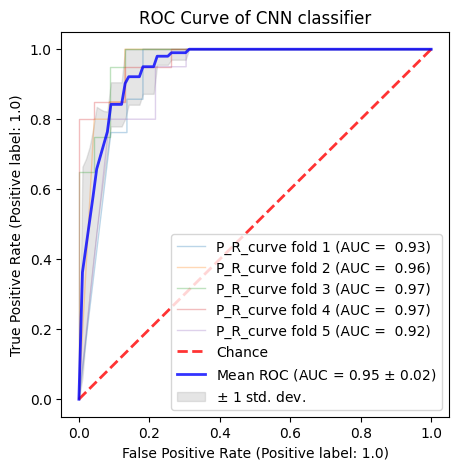

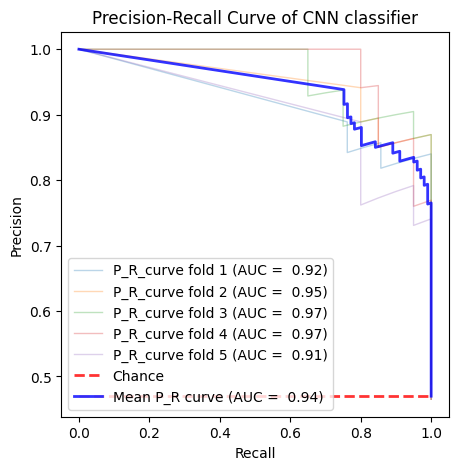

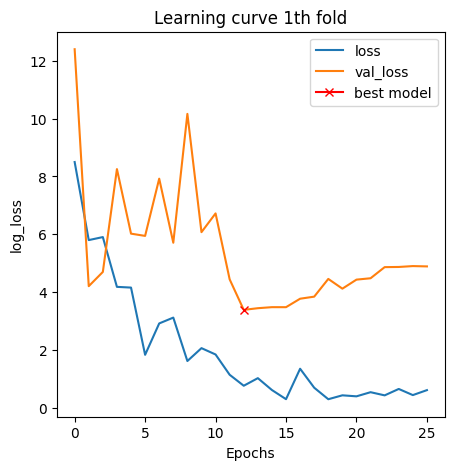

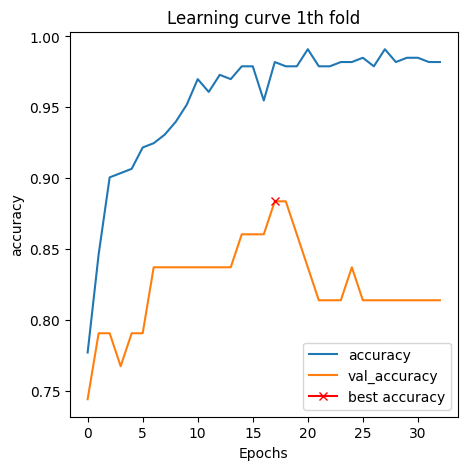

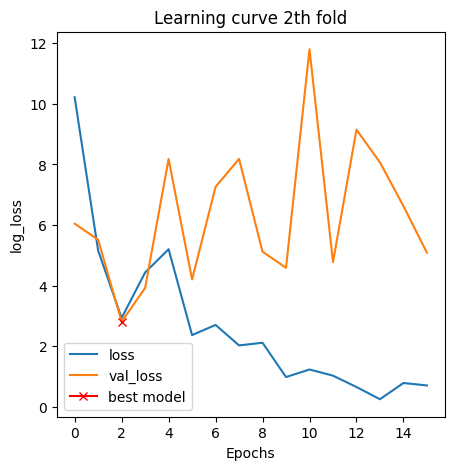

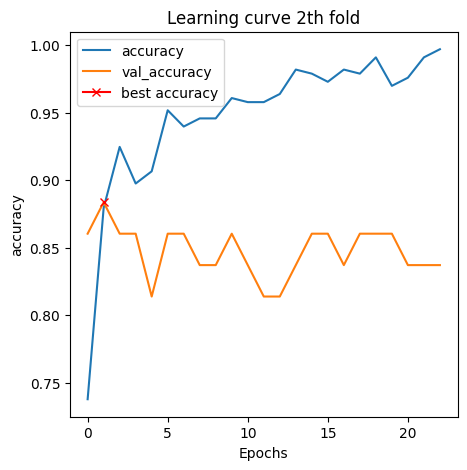

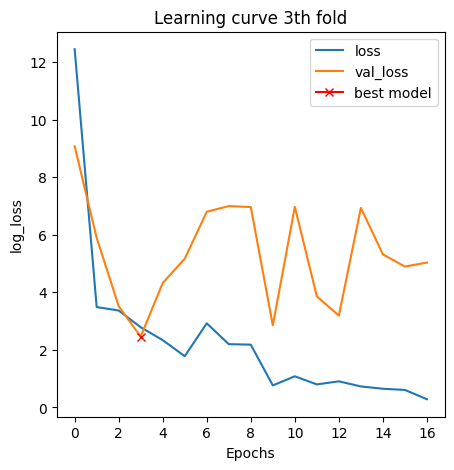

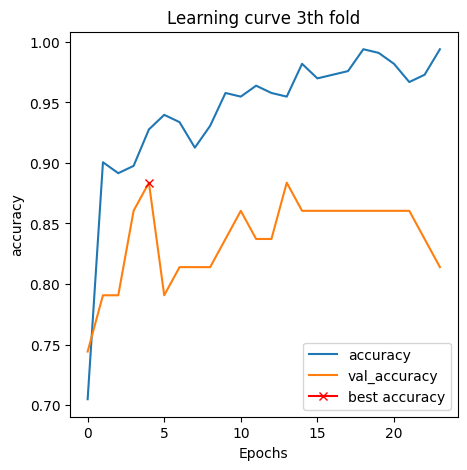

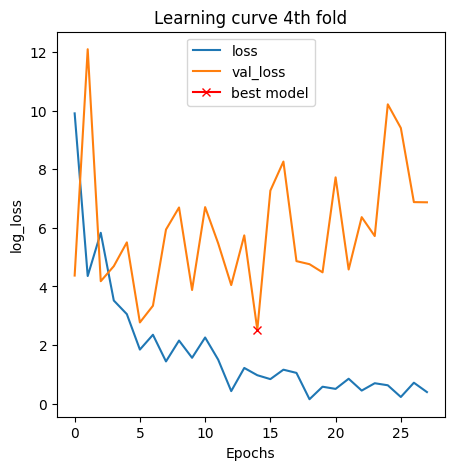

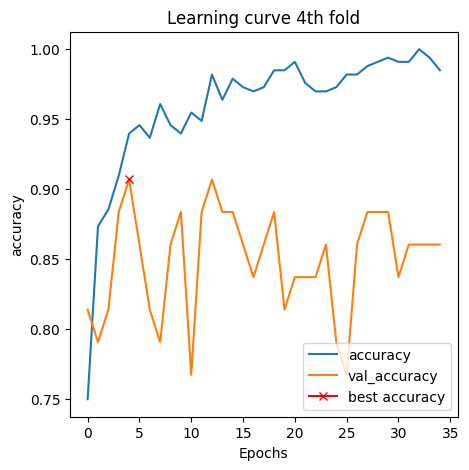

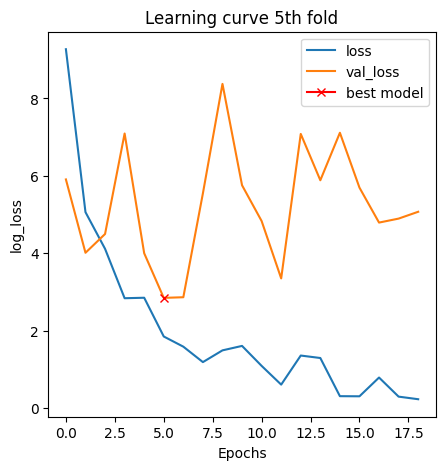

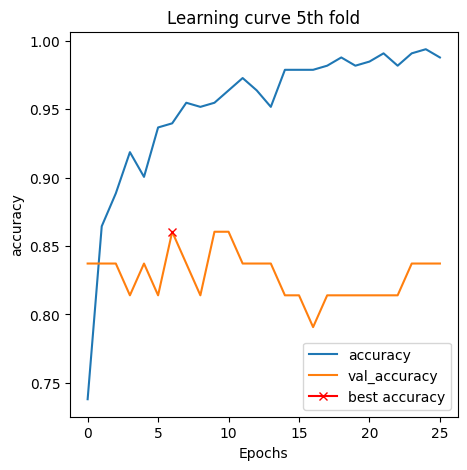

cnn_acc     = 0.851163
cnn_sp      = 0.879669
cnn_se      = 0.838718
cnn_pr      = 0.876391
cnn_f1      = 0.850309
cnn_auc     = 0.949194
cnn_pr_auc  = 0.942925

acc of class Normal = 0.879669
acc of class MS = 0.838718

test_acc     = 0.839286
test_sp      = 0.867099
test_se      = 0.825546
test_pr      = 0.862917
test_f1      = 0.838905
test_auc     = 0.885568
test_pr_auc  = 0.901939

test acc of class Normal = 0.867099
test acc of class MS = 0.825546



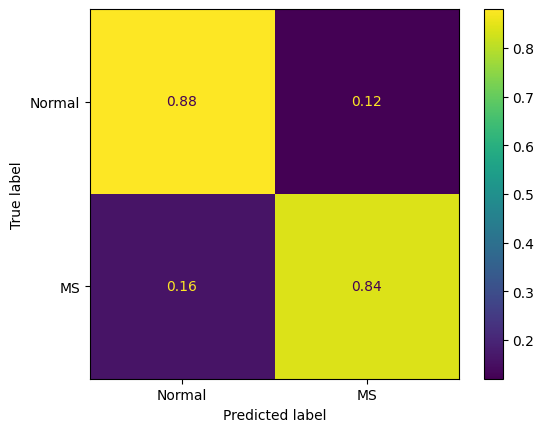

In [17]:
images_train = pickle.load(open("/content/" + "train_slo_iran.pkl", 'rb'))
labels_train = pickle.load(open("/content/" +"train_labels_Iran.pkl", 'rb'))

images_test = pickle.load(open("/content/" +"test_slo_iran.pkl", 'rb'))
labels_test = pickle.load(open("/content/" +"test_labels_Iran.pkl", 'rb'))
images_test,labels_test = preparing(images_test,labels_test)

images_test = np.repeat (images_test, repeats = 3, axis = 3)
#####################################################################
## Parameters
#####################################################################
channel = 3
number_class = 2

cnn_acc    = []
cnn_se     = []
cnn_sp     = []
cnn_pr     = []
cnn_f1     = []
cnn_auc    = []
cnn_pr_auc = []

test_acc    = []
test_se     = []
test_sp     = []
test_pr     = []
test_f1     = []
test_auc    = []
test_pr_auc = []


class_acc = np.zeros((number_class))
class_acc_test = np.zeros((number_class))

target_names = ['Normal' , 'MS']
confusion_matrix = np.zeros((number_class, number_class))
confusion_matrix_test = np.zeros((number_class, number_class))

y_test = []
tprs   = []
aucs   = []
y_pred = []
x_test = {}

mean_fpr  = np.linspace(0, 1, 100)
fig, ax   = plt.subplots(figsize=(5, 5))
fig1, ax1 = plt.subplots(figsize=(5, 5))


#### model parameters for vgg
batch_size_vgg    = 8
epoch         = 100
filter_num    = 32
learning_rate_vgg =  0.0004036650839061106




#### model parameters for res101
batch_size_slo  = 16
epoch         = 100
filter_num    = 32
learning_rate_slo =  0.0001581229399977375


#####################################################################
## Applying kfold
#####################################################################

nfold = 5  #please enter number of folds

kf_nfold = StratifiedKFold(n_splits=nfold, random_state=None, shuffle=True)

n = 0
for train_index, val_index in kf_nfold.split(images_train,list(labels_train.values())):
    n = n+1
    # print(train_index, val_index)  # you can watch train and validation index using this comment
    print(f'---------------------------------------------------------------------\
          \n \t\t\t {n}th fold \n---------------------------------------------------------------------'\
          ,end = '\n\n\n' )
    train_index, val_index = next (skf.split (images_train, list(labels_train.values())))

    x_train = {i: images_train[list(images_train.keys())[i]]  for i in train_index}

    x_valid = {i: images_train[list(images_train.keys())[i]]  for i in val_index}

    y_train = {i: labels_train[list(labels_train.keys())[i]] for i in train_index}

    y_valid = {i: labels_train[list(labels_train.keys())[i]] for i in val_index}

    x_train,y_train = preparing(x_train,y_train)

    x_valid,y_valid = preparing(x_valid,y_valid)

    #x_test[n] = x_valid
    ################# Augmentation


    x_train,y_train = Augmentation_slo (x_train,y_train)

    indices = np.random.permutation (len (x_train))

    x_train = x_train [indices]
    y_train = y_train [indices]

    x_train = np.repeat (x_train, repeats = 3, axis = 3)

    x_valid = np.repeat (x_valid, repeats = 3, axis = 3)

    ####################################################################
    # classification
    ####################################################################

    input_img = Input((np.shape(x_train)[1], np.shape(x_train)[2], channel))

    model = cnn_feature_extractor(input_img)


    METRICS = [
#      keras.metrics.TruePositives(name='tp'),
#      keras.metrics.FalsePositives(name='fp'),
#      keras.metrics.TrueNegatives(name='tn'),
#      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
#      keras.metrics.Precision(name='precision'),
#      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
#      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      ]


    my_optimizer =  tf.keras.optimizers.Adam(lr=learning_rate_slo)
    model.compile(optimizer=my_optimizer, loss="binary_crossentropy", metrics=METRICS)
    callbacks = [EarlyStopping(patience=20, verbose=1),
        ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-6),
        ModelCheckpoint(f'oct{n}.h5', verbose=1, save_best_only=True, save_weights_only=True)]

    model.summary()

    #################################
    ###### Applying model  ###########
    #################################
    results = model.fit(x_train, y_train, batch_size=batch_size_slo, epochs=epoch, callbacks=callbacks,\
                    validation_data=(x_valid, np.asarray(y_valid, dtype=np.float64)))


    plt.figure(figsize=(5, 5))
    plt.title(f"Learning curve {n}th fold")
    plt.plot(results.history["loss"][:-7], label="loss")
    plt.plot(results.history["val_loss"][:-7], label="val_loss")
    plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend()

    plt.figure(figsize=(5, 5))
    plt.title(f"Learning curve {n}th fold")
    plt.plot(results.history["accuracy"], label="accuracy")
    plt.plot(results.history["val_accuracy"], label="val_accuracy")
    plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]),\
             marker="x", color="r", label="best accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("accuracy")
    plt.legend()


    # load the best model
    model.load_weights(f'oct{n}.h5')


    pred_proba = model.predict(x_valid).ravel()
    pred_class = (pred_proba > 0.5).astype(np.uint8)


    ##### calculating metrics

    cnn_acc.append(metrics.accuracy_score(y_valid, pred_class))
    print(f'accuracy of {n}th fold : {metrics.accuracy_score(y_valid, pred_class)}')
    SP, SE, PR, f1, ROC_AUC, P_R_AUC, Class_acc, cm = metrics_calculation(y_valid, pred_class, pred_proba)

    cnn_sp.append(SP)
    cnn_se.append(SE)
    cnn_pr.append(PR)
    cnn_f1.append(f1)
    cnn_auc.append(ROC_AUC)
    cnn_pr_auc.append(P_R_AUC)

    #################### acc for each class ##################
    class_acc  = np.add(class_acc,Class_acc)

    ###################### Total confusion_matrix for poly kernel ############
    confusion_matrix = np.add(confusion_matrix,cm)

######################## internal test
    pred_proba_test = model.predict(images_test).ravel()
    pred_class_test = (pred_proba_test > 0.5).astype(np.uint8)


    ##### calculating metrics
    print(f'test accuracy of {n}th fold : {metrics.accuracy_score(labels_test, pred_class_test)}')
    SP, SE, PR, f1, ROC_AUC, P_R_AUC, Class_acc, cm = metrics_calculation(labels_test, pred_class_test, pred_proba_test)

    test_acc.append(metrics.accuracy_score(labels_test, pred_class_test))
    test_sp.append(SP)
    test_se.append(SE)
    test_pr.append(PR)
    test_f1.append(f1)
    test_auc.append(ROC_AUC)
    test_pr_auc.append(P_R_AUC)

    #################### acc for each class ##################
    class_acc_test  = np.add(class_acc_test,Class_acc)

    ###################### Total confusion_matrix for poly kernel ############
    confusion_matrix_test = np.add(confusion_matrix_test,cm)

    ###################### Ploting ROC and PR curves for each fold ############
    y_test = np.append(y_test, y_valid, axis = 0)
    y_pred = np.append(y_pred, pred_proba, axis = 0)
    ###
    tprs, aucs = fold_curves(ax, ax1, y_valid, n, mean_fpr, pred_proba, tprs, aucs)

######################  the mean Ploting ROC and PR curves ############
###
curve_ploting(ax, ax1, mean_fpr, aucs, tprs, y_test, y_pred, 'CNN' )

plt.show()

#######################################
    # ploting confusion matrix
#######################################
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix/nfold, display_labels=target_names)
disp.plot()


########################################
#     Metrics printing
########################################
cnn_accc     = np.mean(cnn_acc)
cnn_spp      = np.mean(cnn_sp)
cnn_see      = np.mean(cnn_se)
cnn_prr      = np.mean(cnn_pr)
cnn_f11      = np.mean(cnn_f1)
cnn_aucc     = np.mean(cnn_auc)
cnn_pr_aucc  = np.mean(cnn_pr_auc)

###################### internal test
test_accc     = np.mean(test_acc)
test_spp      = np.mean(test_sp)
test_see      = np.mean(test_se)
test_prr      = np.mean(test_pr)
test_f11      = np.mean(test_f1)
test_aucc     = np.mean(test_auc)
test_pr_aucc  = np.mean(test_pr_auc)

#################### acc for each class ##################
class_acc  = class_acc/nfold
class_acc_test  = class_acc_test/nfold

print('cnn_acc     = %f' % cnn_accc)
print('cnn_sp      = %f' % cnn_spp)
print('cnn_se      = %f' % cnn_see)
print('cnn_pr      = %f' % cnn_prr)
print('cnn_f1      = %f' % cnn_f11)
print('cnn_auc     = %f' % cnn_aucc)
print('cnn_pr_auc  = %f' % cnn_pr_aucc, end='\n\n')


print('acc of class %s' % target_names[0], '= %f' % class_acc[0])
print('acc of class %s' % target_names[1], '= %f' % class_acc[1], end='\n\n')

print('test_acc     = %f' % test_accc)
print('test_sp      = %f' % test_spp)
print('test_se      = %f' % test_see)
print('test_pr      = %f' % test_prr)
print('test_f1      = %f' % test_f11)
print('test_auc     = %f' % test_aucc)
print('test_pr_auc  = %f' % test_pr_aucc, end='\n\n')


print('test acc of class %s' % target_names[0], '= %f' % class_acc_test[0])
print('test acc of class %s' % target_names[1], '= %f' % class_acc_test[1], end='\n\n')